<a href="https://colab.research.google.com/github/ykato27/Time-Series-Analysis/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single timestep:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

    8192/13568290 [..............................] - ETA: 0s

 4202496/13568290 [========>.....................] - ETA: 0s

 8396800/13568290 [=================>............] - ETA: 0s

13574144/13568290 [==============================] - 1s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time. 

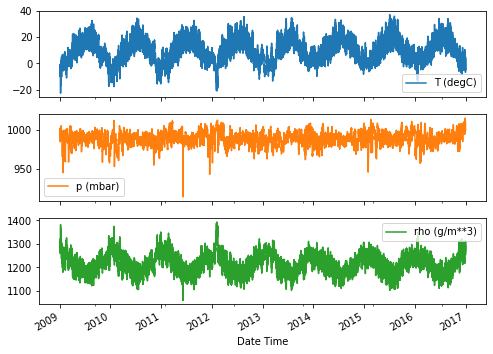

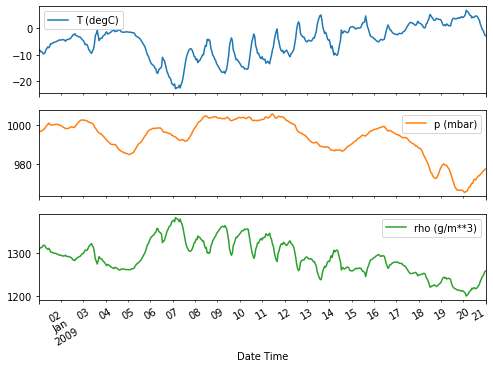

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. 

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

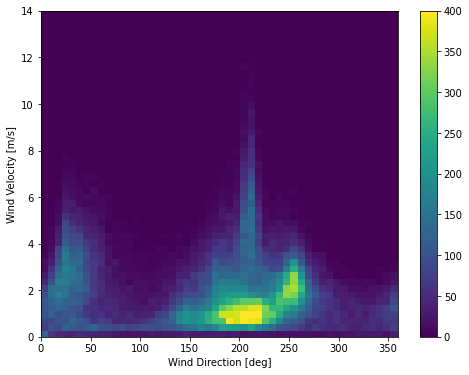

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

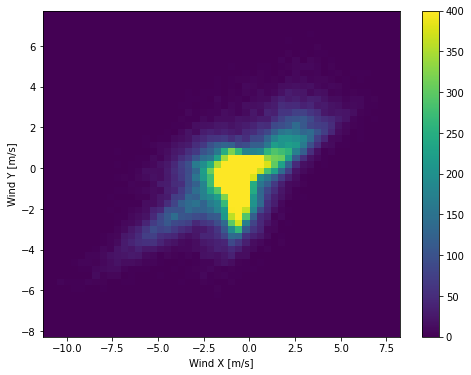

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

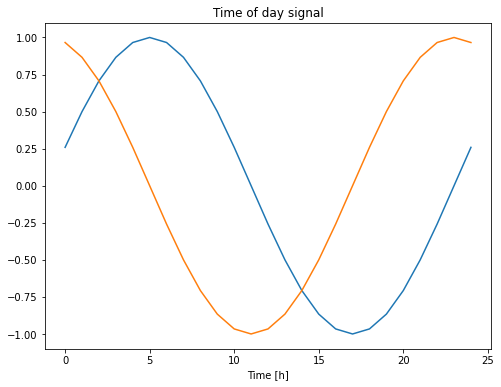

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`: 

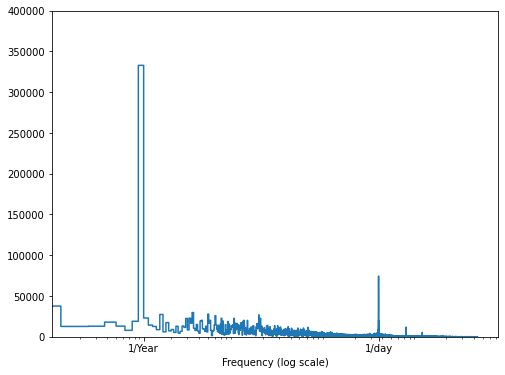

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Split the data

We'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

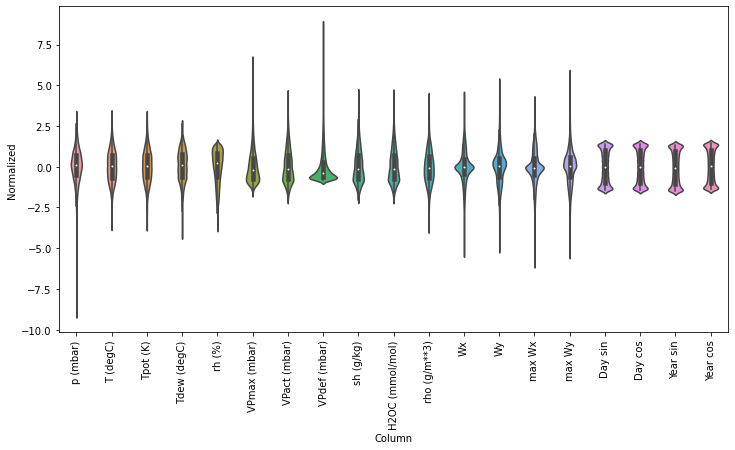

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

* *Single-output*, and *multi-output* predictions.
* *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

  ![One prediction 24h into the future.](images/raw_window_24h.png)

2. A model that makes a prediction 1h into the future, given 6h of history would need a window like this:

  ![One prediction 1h into the future.](images/raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into a `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. Split
Given a list consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2`, above, will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](images/split_window.png)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


Typically data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of 3, 7-timestep windows, with 19 features at each time step. It split them into a batch of 6-timestep, 19 feature inputs, and a 1-timestep 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

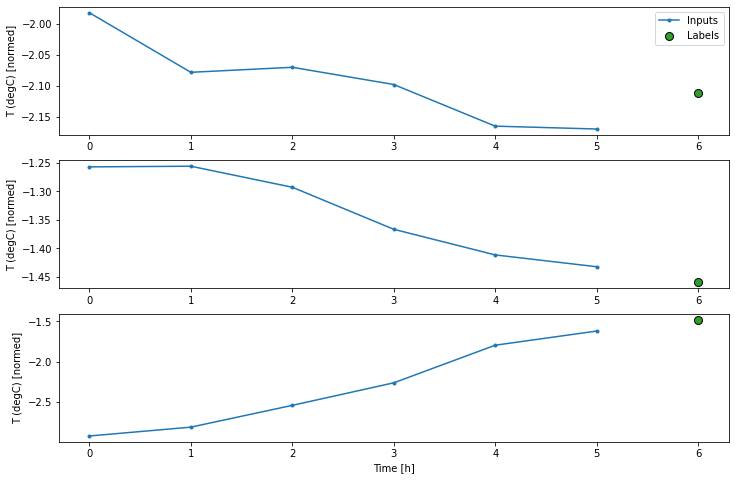

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

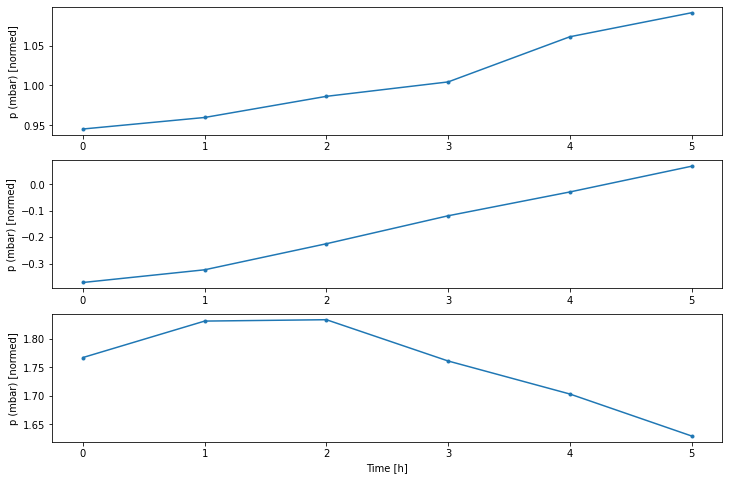

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Create `tf.data.Dataset`s

Finally this `make_dataset` method will take a time series `DataFrame` and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `preprocessing.timeseries_dataset_from_array` function.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation and test data. Add properties for accessing them as `tf.data.Datasets` using the above `make_dataset` method. Also add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, `dtypes` and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value, 1 timestep (1h) in the future based only on the current conditions.

So start by building models to predict the `T (degC)` value 1h into the future.

![Predict the next time step](images/narrow_window.png)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

The `window` object creates `tf.data.Datasets` from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature 1h in the future given the current value of all features. The current values include the current temperature. 

So start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](images/baseline.png)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 1:19 - loss: 0.0159 - mean_absolute_error: 0.0895

 23/439 [>.............................] - ETA: 0s - loss: 0.0165 - mean_absolute_error: 0.0919  

 46/439 [==>...........................] - ETA: 0s - loss: 0.0154 - mean_absolute_error: 0.0880

 70/439 [===>..........................] - ETA: 0s - loss: 0.0148 - mean_absolute_error: 0.0855

 94/439 [=====>........................] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.0838

118/439 [=======>......................] - ETA: 0s - loss: 0.0142 - mean_absolute_error: 0.0831

143/439 [========>.....................] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.0826

167/439 [==========>...................] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.0822

192/439 [============>.................] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.0818

216/439 [=============>................] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0816

240/439 [===============>..............] - ETA: 0s - loss: 0.0137 - mean_absolute_error: 0.0814

264/439 [=================>............] - ETA: 0s - loss: 0.0136 - mean_absolute_error: 0.0812

288/439 [==================>...........] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0810

313/439 [====================>.........] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0808

338/439 [======================>.......] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0807

362/439 [=======================>......] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0806

386/439 [=========================>....] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0805

410/439 [===========================>..] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0804

431/439 [============================>.] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.0803

439/439 [==============================] - 1s 2ms/step - loss: 0.0133 - mean_absolute_error: 0.0802


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample. So, create a wider `WindowGenerator` that generates windows 24h of consecutive inputs and labels at a time. 

The `wide_window` doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. Here the `time` axis acts like the `batch` axis: Each prediction is made independently with no interaction between time steps.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of timesteps, and the baseline just forwards the input to the output:

  ![One prediction 1h into the future, ever hour.](images/last_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Plotting the baseline model's predictions you can see that it is simply the labels, shifted right by 1h.

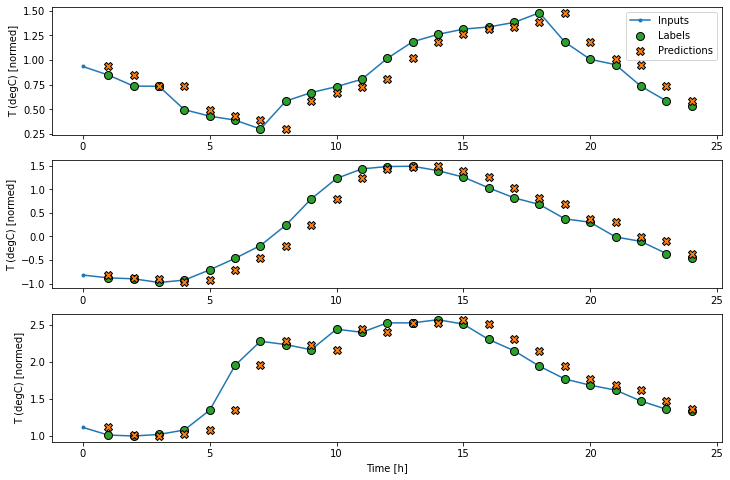

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24h. This deserves some explanation:

* The blue "Inputs" line shows the input temperature at each time step. The model recieves all features, this plot only shows the temperature.
* The green "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](images/narrow_window.png)

A `layers.Dense` with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`, it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)


Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 8:34 - loss: 2.8495 - mean_absolute_error: 1.3524

  20/1534 [..............................] - ETA: 4s - loss: 2.6962 - mean_absolute_error: 1.3295  

  39/1534 [..............................] - ETA: 4s - loss: 2.5793 - mean_absolute_error: 1.2986

  57/1534 [>.............................] - ETA: 4s - loss: 2.4352 - mean_absolute_error: 1.2621

  75/1534 [>.............................] - ETA: 4s - loss: 2.3104 - mean_absolute_error: 1.2277

  94/1534 [>.............................] - ETA: 3s - loss: 2.1984 - mean_absolute_error: 1.1953

 112/1534 [=>............................] - ETA: 3s - loss: 2.1053 - mean_absolute_error: 1.1670

 131/1534 [=>............................] - ETA: 3s - loss: 2.0169 - mean_absolute_error: 1.1390

 150/1534 [=>............................] - ETA: 3s - loss: 1.9366 - mean_absolute_error: 1.1124

 170/1534 [==>...........................] - ETA: 3s - loss: 1.8598 - mean_absolute_error: 1.0862

 190/1534 [==>...........................] - ETA: 3s - loss: 1.7897 - mean_absolute_error: 1.0614

 209/1534 [===>..........................] - ETA: 3s - loss: 1.7289 - mean_absolute_error: 1.0394

 229/1534 [===>..........................] - ETA: 3s - loss: 1.6700 - mean_absolute_error: 1.0175

 248/1534 [===>..........................] - ETA: 3s - loss: 1.6184 - mean_absolute_error: 0.9980

 267/1534 [====>.........................] - ETA: 3s - loss: 1.5707 - mean_absolute_error: 0.9795

 287/1534 [====>.........................] - ETA: 3s - loss: 1.5241 - mean_absolute_error: 0.9611

 307/1534 [=====>........................] - ETA: 3s - loss: 1.4809 - mean_absolute_error: 0.9437

 326/1534 [=====>........................] - ETA: 3s - loss: 1.4427 - mean_absolute_error: 0.9282

 346/1534 [=====>........................] - ETA: 3s - loss: 1.4054 - mean_absolute_error: 0.9128

 366/1534 [======>.......................] - ETA: 3s - loss: 1.3705 - mean_absolute_error: 0.8982

 386/1534 [======>.......................] - ETA: 3s - loss: 1.3378 - mean_absolute_error: 0.8844

 405/1534 [======>.......................] - ETA: 2s - loss: 1.3086 - mean_absolute_error: 0.8719

 424/1534 [=======>......................] - ETA: 2s - loss: 1.2810 - mean_absolute_error: 0.8599

 444/1534 [=======>......................] - ETA: 2s - loss: 1.2536 - mean_absolute_error: 0.8479

 464/1534 [========>.....................] - ETA: 2s - loss: 1.2277 - mean_absolute_error: 0.8365

 484/1534 [========>.....................] - ETA: 2s - loss: 1.2031 - mean_absolute_error: 0.8255

 504/1534 [========>.....................] - ETA: 2s - loss: 1.1798 - mean_absolute_error: 0.8151

 523/1534 [=========>....................] - ETA: 2s - loss: 1.1587 - mean_absolute_error: 0.8055

 543/1534 [=========>....................] - ETA: 2s - loss: 1.1375 - mean_absolute_error: 0.7959

 563/1534 [==========>...................] - ETA: 2s - loss: 1.1173 - mean_absolute_error: 0.7866

 583/1534 [==========>...................] - ETA: 2s - loss: 1.0981 - mean_absolute_error: 0.7777

 603/1534 [==========>...................] - ETA: 2s - loss: 1.0797 - mean_absolute_error: 0.7692

 622/1534 [===========>..................] - ETA: 2s - loss: 1.0630 - mean_absolute_error: 0.7614

 642/1534 [===========>..................] - ETA: 2s - loss: 1.0461 - mean_absolute_error: 0.7534

 661/1534 [===========>..................] - ETA: 2s - loss: 1.0307 - mean_absolute_error: 0.7461

 681/1534 [============>.................] - ETA: 2s - loss: 1.0151 - mean_absolute_error: 0.7387

 701/1534 [============>.................] - ETA: 2s - loss: 1.0001 - mean_absolute_error: 0.7316

 721/1534 [=============>................] - ETA: 2s - loss: 0.9857 - mean_absolute_error: 0.7246

 741/1534 [=============>................] - ETA: 2s - loss: 0.9718 - mean_absolute_error: 0.7180

 760/1534 [=============>................] - ETA: 2s - loss: 0.9590 - mean_absolute_error: 0.7118

 779/1534 [==============>...............] - ETA: 1s - loss: 0.9467 - mean_absolute_error: 0.7058

 798/1534 [==============>...............] - ETA: 1s - loss: 0.9348 - mean_absolute_error: 0.7000

 818/1534 [==============>...............] - ETA: 1s - loss: 0.9227 - mean_absolute_error: 0.6941

 838/1534 [===============>..............] - ETA: 1s - loss: 0.9110 - mean_absolute_error: 0.6883

 858/1534 [===============>..............] - ETA: 1s - loss: 0.8997 - mean_absolute_error: 0.6828

 878/1534 [================>.............] - ETA: 1s - loss: 0.8888 - mean_absolute_error: 0.6774

 898/1534 [================>.............] - ETA: 1s - loss: 0.8782 - mean_absolute_error: 0.6721

 917/1534 [================>.............] - ETA: 1s - loss: 0.8684 - mean_absolute_error: 0.6672

 937/1534 [=================>............] - ETA: 1s - loss: 0.8584 - mean_absolute_error: 0.6622

 956/1534 [=================>............] - ETA: 1s - loss: 0.8492 - mean_absolute_error: 0.6575

 975/1534 [==================>...........] - ETA: 1s - loss: 0.8402 - mean_absolute_error: 0.6530

 994/1534 [==================>...........] - ETA: 1s - loss: 0.8314 - mean_absolute_error: 0.6486

1013/1534 [==================>...........] - ETA: 1s - loss: 0.8229 - mean_absolute_error: 0.6443

1033/1534 [===================>..........] - ETA: 1s - loss: 0.8142 - mean_absolute_error: 0.6398

1052/1534 [===================>..........] - ETA: 1s - loss: 0.8061 - mean_absolute_error: 0.6357

1072/1534 [===================>..........] - ETA: 1s - loss: 0.7978 - mean_absolute_error: 0.6314

1091/1534 [====================>.........] - ETA: 1s - loss: 0.7902 - mean_absolute_error: 0.6274

1111/1534 [====================>.........] - ETA: 1s - loss: 0.7823 - mean_absolute_error: 0.6234

1131/1534 [=====================>........] - ETA: 1s - loss: 0.7746 - mean_absolute_error: 0.6194

1150/1534 [=====================>........] - ETA: 1s - loss: 0.7675 - mean_absolute_error: 0.6157

1169/1534 [=====================>........] - ETA: 0s - loss: 0.7605 - mean_absolute_error: 0.6120

1188/1534 [======================>.......] - ETA: 0s - loss: 0.7537 - mean_absolute_error: 0.6085

1208/1534 [======================>.......] - ETA: 0s - loss: 0.7467 - mean_absolute_error: 0.6048

1227/1534 [======================>.......] - ETA: 0s - loss: 0.7402 - mean_absolute_error: 0.6013

1247/1534 [=======================>......] - ETA: 0s - loss: 0.7336 - mean_absolute_error: 0.5978

1266/1534 [=======================>......] - ETA: 0s - loss: 0.7274 - mean_absolute_error: 0.5945

1286/1534 [========================>.....] - ETA: 0s - loss: 0.7210 - mean_absolute_error: 0.5911

1306/1534 [========================>.....] - ETA: 0s - loss: 0.7147 - mean_absolute_error: 0.5877

1325/1534 [========================>.....] - ETA: 0s - loss: 0.7089 - mean_absolute_error: 0.5846

1345/1534 [=========================>....] - ETA: 0s - loss: 0.7029 - mean_absolute_error: 0.5814

1364/1534 [=========================>....] - ETA: 0s - loss: 0.6973 - mean_absolute_error: 0.5783

1383/1534 [==========================>...] - ETA: 0s - loss: 0.6918 - mean_absolute_error: 0.5754

1403/1534 [==========================>...] - ETA: 0s - loss: 0.6862 - mean_absolute_error: 0.5723

1423/1534 [==========================>...] - ETA: 0s - loss: 0.6806 - mean_absolute_error: 0.5693

1442/1534 [===========================>..] - ETA: 0s - loss: 0.6755 - mean_absolute_error: 0.5664

1462/1534 [===========================>..] - ETA: 0s - loss: 0.6701 - mean_absolute_error: 0.5635

1481/1534 [===========================>..] - ETA: 0s - loss: 0.6652 - mean_absolute_error: 0.5608

1499/1534 [============================>.] - ETA: 0s - loss: 0.6605 - mean_absolute_error: 0.5582

1519/1534 [============================>.] - ETA: 0s - loss: 0.6555 - mean_absolute_error: 0.5554

1534/1534 [==============================] - 6s 4ms/step - loss: 0.6515 - mean_absolute_error: 0.5532 - val_loss: 0.0476 - val_mean_absolute_error: 0.1473


Epoch 2/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0517 - mean_absolute_error: 0.1696

  21/1534 [..............................] - ETA: 3s - loss: 0.0627 - mean_absolute_error: 0.1735 

  40/1534 [..............................] - ETA: 3s - loss: 0.0591 - mean_absolute_error: 0.1697

  59/1534 [>.............................] - ETA: 3s - loss: 0.0567 - mean_absolute_error: 0.1669

  78/1534 [>.............................] - ETA: 3s - loss: 0.0555 - mean_absolute_error: 0.1656

  97/1534 [>.............................] - ETA: 3s - loss: 0.0546 - mean_absolute_error: 0.1647

 117/1534 [=>............................] - ETA: 3s - loss: 0.0537 - mean_absolute_error: 0.1639

 136/1534 [=>............................] - ETA: 3s - loss: 0.0530 - mean_absolute_error: 0.1631

 155/1534 [==>...........................] - ETA: 3s - loss: 0.0524 - mean_absolute_error: 0.1624

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0518 - mean_absolute_error: 0.1616

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0512 - mean_absolute_error: 0.1609

 215/1534 [===>..........................] - ETA: 3s - loss: 0.0507 - mean_absolute_error: 0.1602

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0502 - mean_absolute_error: 0.1595

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0498 - mean_absolute_error: 0.1587

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0493 - mean_absolute_error: 0.1580

 293/1534 [====>.........................] - ETA: 3s - loss: 0.0488 - mean_absolute_error: 0.1573

 313/1534 [=====>........................] - ETA: 3s - loss: 0.0484 - mean_absolute_error: 0.1567

 332/1534 [=====>........................] - ETA: 3s - loss: 0.0480 - mean_absolute_error: 0.1561

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0476 - mean_absolute_error: 0.1555

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0473 - mean_absolute_error: 0.1549

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0469 - mean_absolute_error: 0.1544

 409/1534 [======>.......................] - ETA: 2s - loss: 0.0466 - mean_absolute_error: 0.1538

 428/1534 [=======>......................] - ETA: 2s - loss: 0.0463 - mean_absolute_error: 0.1533

 447/1534 [=======>......................] - ETA: 2s - loss: 0.0460 - mean_absolute_error: 0.1528

 467/1534 [========>.....................] - ETA: 2s - loss: 0.0457 - mean_absolute_error: 0.1522

 487/1534 [========>.....................] - ETA: 2s - loss: 0.0453 - mean_absolute_error: 0.1517

 507/1534 [========>.....................] - ETA: 2s - loss: 0.0450 - mean_absolute_error: 0.1512

 527/1534 [=========>....................] - ETA: 2s - loss: 0.0447 - mean_absolute_error: 0.1507

 547/1534 [=========>....................] - ETA: 2s - loss: 0.0444 - mean_absolute_error: 0.1502

 563/1534 [==========>...................] - ETA: 2s - loss: 0.0442 - mean_absolute_error: 0.1498

 583/1534 [==========>...................] - ETA: 2s - loss: 0.0439 - mean_absolute_error: 0.1493

 603/1534 [==========>...................] - ETA: 2s - loss: 0.0436 - mean_absolute_error: 0.1488

 623/1534 [===========>..................] - ETA: 2s - loss: 0.0434 - mean_absolute_error: 0.1483

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0431 - mean_absolute_error: 0.1478

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0428 - mean_absolute_error: 0.1474

 683/1534 [============>.................] - ETA: 2s - loss: 0.0426 - mean_absolute_error: 0.1469

 703/1534 [============>.................] - ETA: 2s - loss: 0.0423 - mean_absolute_error: 0.1465

 723/1534 [=============>................] - ETA: 2s - loss: 0.0421 - mean_absolute_error: 0.1460

 743/1534 [=============>................] - ETA: 2s - loss: 0.0418 - mean_absolute_error: 0.1456

 763/1534 [=============>................] - ETA: 2s - loss: 0.0416 - mean_absolute_error: 0.1451

 782/1534 [==============>...............] - ETA: 1s - loss: 0.0414 - mean_absolute_error: 0.1447

 801/1534 [==============>...............] - ETA: 1s - loss: 0.0411 - mean_absolute_error: 0.1443

 820/1534 [===============>..............] - ETA: 1s - loss: 0.0409 - mean_absolute_error: 0.1439

 840/1534 [===============>..............] - ETA: 1s - loss: 0.0407 - mean_absolute_error: 0.1435

 860/1534 [===============>..............] - ETA: 1s - loss: 0.0405 - mean_absolute_error: 0.1431

 879/1534 [================>.............] - ETA: 1s - loss: 0.0403 - mean_absolute_error: 0.1427

 899/1534 [================>.............] - ETA: 1s - loss: 0.0400 - mean_absolute_error: 0.1423

 919/1534 [================>.............] - ETA: 1s - loss: 0.0398 - mean_absolute_error: 0.1419

 938/1534 [=================>............] - ETA: 1s - loss: 0.0396 - mean_absolute_error: 0.1415

 958/1534 [=================>............] - ETA: 1s - loss: 0.0394 - mean_absolute_error: 0.1411

 978/1534 [==================>...........] - ETA: 1s - loss: 0.0392 - mean_absolute_error: 0.1407

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.1404

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0388 - mean_absolute_error: 0.1400

1036/1534 [===================>..........] - ETA: 1s - loss: 0.0386 - mean_absolute_error: 0.1396

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0384 - mean_absolute_error: 0.1393

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0382 - mean_absolute_error: 0.1389

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0380 - mean_absolute_error: 0.1385

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0379 - mean_absolute_error: 0.1382

1134/1534 [=====================>........] - ETA: 1s - loss: 0.0377 - mean_absolute_error: 0.1378

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0375 - mean_absolute_error: 0.1375

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0373 - mean_absolute_error: 0.1371

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.1368

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.1365

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.1361

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.1358

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.1354

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.1351

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.1348

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.1345

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.1341

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.1338

1389/1534 [==========================>...] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.1335

1409/1534 [==========================>...] - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.1332

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.1329

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0351 - mean_absolute_error: 0.1325

1469/1534 [===========================>..] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.1322

1488/1534 [============================>.] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.1320

1508/1534 [============================>.] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.1316

1526/1534 [============================>.] - ETA: 0s - loss: 0.0345 - mean_absolute_error: 0.1314

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.1312 - val_loss: 0.0107 - val_mean_absolute_error: 0.0756


Epoch 3/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0158 - mean_absolute_error: 0.0937

  20/1534 [..............................] - ETA: 4s - loss: 0.0119 - mean_absolute_error: 0.0826 

  39/1534 [..............................] - ETA: 4s - loss: 0.0121 - mean_absolute_error: 0.0825

  58/1534 [>.............................] - ETA: 3s - loss: 0.0120 - mean_absolute_error: 0.0817

  77/1534 [>.............................] - ETA: 3s - loss: 0.0120 - mean_absolute_error: 0.0813

  96/1534 [>.............................] - ETA: 3s - loss: 0.0119 - mean_absolute_error: 0.0810

 115/1534 [=>............................] - ETA: 3s - loss: 0.0119 - mean_absolute_error: 0.0808

 132/1534 [=>............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0805

 151/1534 [=>............................] - ETA: 3s - loss: 0.0118 - mean_absolute_error: 0.0804

 171/1534 [==>...........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0802

 190/1534 [==>...........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0801

 209/1534 [===>..........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0800

 229/1534 [===>..........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0799

 248/1534 [===>..........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0798

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0117 - mean_absolute_error: 0.0796

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0795

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0794

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0793

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0116 - mean_absolute_error: 0.0792

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0791

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0790

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0115 - mean_absolute_error: 0.0789

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0115 - mean_absolute_error: 0.0788

 443/1534 [=======>......................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0787

 463/1534 [========>.....................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0786

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0785

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0114 - mean_absolute_error: 0.0784

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0783

 540/1534 [=========>....................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0782

 560/1534 [=========>....................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0781

 579/1534 [==========>...................] - ETA: 2s - loss: 0.0113 - mean_absolute_error: 0.0780

 598/1534 [==========>...................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0780

 617/1534 [===========>..................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0779

 636/1534 [===========>..................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0778

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0778

 676/1534 [============>.................] - ETA: 2s - loss: 0.0112 - mean_absolute_error: 0.0777

 696/1534 [============>.................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0776

 713/1534 [============>.................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0776

 733/1534 [=============>................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0775

 752/1534 [=============>................] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0775

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0111 - mean_absolute_error: 0.0774

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0774

 811/1534 [==============>...............] - ETA: 1s - loss: 0.0111 - mean_absolute_error: 0.0773

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0772

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0772

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0771

 889/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0771

 909/1534 [================>.............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0770

 929/1534 [=================>............] - ETA: 1s - loss: 0.0110 - mean_absolute_error: 0.0770

 948/1534 [=================>............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0769

 968/1534 [=================>............] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0769

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

1008/1534 [==================>...........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0768

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0767

1067/1534 [===================>..........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0767

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0109 - mean_absolute_error: 0.0766

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0766

1126/1534 [=====================>........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1145/1534 [=====================>........] - ETA: 1s - loss: 0.0108 - mean_absolute_error: 0.0765

1164/1534 [=====================>........] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0765

1183/1534 [======================>.......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0764

1203/1534 [======================>.......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0764

1223/1534 [======================>.......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0763

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0763

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0108 - mean_absolute_error: 0.0763

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1299/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0762

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0761

1378/1534 [=========================>....] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0760

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0760

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0760

1435/1534 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0759

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.0759

1473/1534 [===========================>..] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0759

1493/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0758

1512/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0758

1529/1534 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0758

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0106 - mean_absolute_error: 0.0758 - val_loss: 0.0091 - val_mean_absolute_error: 0.0705


Epoch 4/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0092 - mean_absolute_error: 0.0712

  21/1534 [..............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0740 

  41/1534 [..............................] - ETA: 3s - loss: 0.0098 - mean_absolute_error: 0.0739

  61/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0733

  81/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0731

 100/1534 [>.............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0729

 120/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0728

 139/1534 [=>............................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 158/1534 [==>...........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 177/1534 [==>...........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 196/1534 [==>...........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0727

 216/1534 [===>..........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0726

 235/1534 [===>..........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0726

 254/1534 [===>..........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0725

 273/1534 [====>.........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0725

 292/1534 [====>.........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0724

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0724

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0724

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0723

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0097 - mean_absolute_error: 0.0722

 406/1534 [======>.......................] - ETA: 2s - loss: 0.0097 - mean_absolute_error: 0.0722

 425/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 445/1534 [=======>......................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0721

 464/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0720

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0719

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0096 - mean_absolute_error: 0.0718

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 614/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 633/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0717

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 671/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 690/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 709/1534 [============>.................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 728/1534 [=============>................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 747/1534 [=============>................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0716

 766/1534 [=============>................] - ETA: 2s - loss: 0.0095 - mean_absolute_error: 0.0715

 786/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 806/1534 [==============>...............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 825/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 844/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0715

 864/1534 [===============>..............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 883/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 902/1534 [================>.............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 921/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 941/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 960/1534 [=================>............] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0714

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0713

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1115/1534 [====================>.........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0094 - mean_absolute_error: 0.0713

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1192/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1211/1534 [======================>.......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1230/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1249/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0712

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1498/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1517/1534 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0711

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0711 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700


Epoch 5/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0091 - mean_absolute_error: 0.0803

  21/1534 [..............................] - ETA: 4s - loss: 0.0095 - mean_absolute_error: 0.0709 

  40/1534 [..............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

  59/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

  78/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

  97/1534 [>.............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 116/1534 [=>............................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0709

 135/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 192/1534 [==>...........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 211/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 230/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 249/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 268/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 288/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 367/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 386/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0711

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 518/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0710

 537/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 556/1534 [=========>....................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0709

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0094 - mean_absolute_error: 0.0708

 675/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 695/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 714/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 733/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 752/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 811/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0708

 870/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 890/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 910/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 930/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 949/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 968/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1006/1534 [==================>...........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0707

1159/1534 [=====================>........] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1178/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0707

1197/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1217/1534 [======================>.......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1236/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1275/1534 [=======================>......] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1408/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1484/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1503/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1522/1534 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0706

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0705 - val_loss: 0.0089 - val_mean_absolute_error: 0.0698


Epoch 6/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0085 - mean_absolute_error: 0.0710

  20/1534 [..............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0676 

  40/1534 [..............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0689

  60/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0693

  79/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0697

  99/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 119/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0701

 138/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0703

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 214/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 233/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 271/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 290/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 309/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 328/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 347/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0708

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 424/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 444/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 464/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 483/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 502/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 521/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 673/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 692/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 712/1534 [============>.................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 732/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 751/1534 [=============>................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 789/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 808/1534 [==============>...............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 828/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 847/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0705

 887/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

 906/1534 [================>.............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

 926/1534 [=================>............] - ETA: 1s - loss: 0.0093 - mean_absolute_error: 0.0704

 945/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 964/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1100/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1119/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1159/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1178/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1198/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1218/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1314/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1391/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1487/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1506/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1525/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0089 - val_mean_absolute_error: 0.0699


Epoch 7/20
   1/1534 [..............................] - ETA: 26s - loss: 0.0096 - mean_absolute_error: 0.0716

  20/1534 [..............................] - ETA: 4s - loss: 0.0088 - mean_absolute_error: 0.0701 

  40/1534 [..............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0706

  60/1534 [>.............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0707

  79/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0708

  99/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0708

 118/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0709

 137/1534 [=>............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0709

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0710

 175/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

 194/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0711

 213/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0712

 232/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0712

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0711

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0710

 442/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0709

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0708

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 576/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 615/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0707

 655/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 674/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0707

 693/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 713/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 732/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 752/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0706

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 830/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 849/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0706

 888/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 907/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 927/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 946/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 965/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1118/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1137/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1156/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0705

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1405/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1424/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1482/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1501/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0704

1520/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0703 - val_loss: 0.0088 - val_mean_absolute_error: 0.0695


Epoch 8/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0071 - mean_absolute_error: 0.0598

  20/1534 [..............................] - ETA: 3s - loss: 0.0077 - mean_absolute_error: 0.0643 

  39/1534 [..............................] - ETA: 3s - loss: 0.0083 - mean_absolute_error: 0.0666

  58/1534 [>.............................] - ETA: 3s - loss: 0.0086 - mean_absolute_error: 0.0677

  77/1534 [>.............................] - ETA: 3s - loss: 0.0087 - mean_absolute_error: 0.0682

  96/1534 [>.............................] - ETA: 3s - loss: 0.0088 - mean_absolute_error: 0.0686

 116/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0690

 135/1534 [=>............................] - ETA: 3s - loss: 0.0089 - mean_absolute_error: 0.0692

 154/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0694

 173/1534 [==>...........................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0696

 193/1534 [==>...........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

 213/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 232/1534 [===>..........................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0700

 251/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 270/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 289/1534 [====>.........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 308/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 327/1534 [=====>........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

 422/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 441/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 461/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0702

 480/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 499/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 538/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 557/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 596/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 673/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 692/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 712/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 732/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 751/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 771/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 791/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 810/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 829/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 848/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 867/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 887/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 906/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 925/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 944/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 964/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1060/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1080/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1097/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1175/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1194/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1213/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1232/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1290/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1347/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1480/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1499/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1518/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0696


Epoch 9/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0048 - mean_absolute_error: 0.0562

  20/1534 [..............................] - ETA: 4s - loss: 0.0096 - mean_absolute_error: 0.0703 

  39/1534 [..............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0703

  59/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

  79/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0703

  98/1534 [>.............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0704

 117/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0704

 137/1534 [=>............................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 157/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 212/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 232/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 252/1534 [===>..........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 311/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 349/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 388/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 407/1534 [======>.......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 426/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 445/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 465/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 484/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 504/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0705

 524/1534 [=========>....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 543/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 562/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 582/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 602/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 621/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 640/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 679/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 699/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 719/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 739/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 759/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 779/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

 798/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 818/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 838/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 858/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 878/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 898/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 918/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 937/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 956/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1072/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1129/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1148/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1167/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1187/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1207/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1226/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0701

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1363/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1421/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1498/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1517/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0690


Epoch 10/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0075 - mean_absolute_error: 0.0688

  18/1534 [..............................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0712 

  35/1534 [..............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0714

  52/1534 [>.............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0714

  69/1534 [>.............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0714

  86/1534 [>.............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0713

 103/1534 [=>............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0713

 120/1534 [=>............................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0712

 136/1534 [=>............................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0712

 153/1534 [=>............................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0713

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0713

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0713

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0713

 220/1534 [===>..........................] - ETA: 4s - loss: 0.0094 - mean_absolute_error: 0.0713

 236/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0713

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 269/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 286/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 302/1534 [====>.........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0712

 319/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 335/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 351/1534 [=====>........................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0711

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 401/1534 [======>.......................] - ETA: 3s - loss: 0.0094 - mean_absolute_error: 0.0710

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0710

 435/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 501/1534 [========>.....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 567/1534 [==========>...................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 584/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 601/1534 [==========>...................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 618/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 652/1534 [===========>..................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0706

 668/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 685/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 702/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 719/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 736/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 753/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 787/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0705

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 853/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 870/1534 [================>.............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 886/1534 [================>.............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 903/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 920/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 937/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 954/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 971/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0704

1004/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1021/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1054/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1103/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1137/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1204/1534 [======================>.......] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0703

1220/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0703

1270/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1336/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1369/1534 [=========================>....] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1418/1534 [==========================>...] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1451/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1467/1534 [===========================>..] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1484/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1500/1534 [============================>.] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1516/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1531/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0702 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


Epoch 11/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0086 - mean_absolute_error: 0.0738

  17/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0714 

  34/1534 [..............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0708

  51/1534 [..............................] - ETA: 4s - loss: 0.0090 - mean_absolute_error: 0.0704

  67/1534 [>.............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0703

  83/1534 [>.............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0704

  99/1534 [>.............................] - ETA: 4s - loss: 0.0091 - mean_absolute_error: 0.0705

 116/1534 [=>............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0706

 133/1534 [=>............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0706

 150/1534 [=>............................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0707

 167/1534 [==>...........................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0708

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0708

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0709

 216/1534 [===>..........................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0709

 232/1534 [===>..........................] - ETA: 4s - loss: 0.0092 - mean_absolute_error: 0.0709

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0093 - mean_absolute_error: 0.0709

 265/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 281/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0709

 298/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 314/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 330/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 346/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0708

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 413/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0707

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0706

 496/1534 [========>.....................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0706

 513/1534 [=========>....................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 529/1534 [=========>....................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 545/1534 [=========>....................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 562/1534 [=========>....................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 578/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 595/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 611/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 628/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 644/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 677/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 694/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0704

 710/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 726/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 743/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 760/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 777/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 793/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 809/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 875/1534 [================>.............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 891/1534 [================>.............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 908/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 925/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 942/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 959/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

 993/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1042/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1110/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1127/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1160/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1194/1534 [======================>.......] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1212/1534 [======================>.......] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0702

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0702

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0702

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1401/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1420/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1439/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1459/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1498/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1517/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0701

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0091 - mean_absolute_error: 0.0701 - val_loss: 0.0088 - val_mean_absolute_error: 0.0691


Epoch 12/20
   1/1534 [..............................] - ETA: 27s - loss: 0.0045 - mean_absolute_error: 0.0492

  20/1534 [..............................] - ETA: 4s - loss: 0.0089 - mean_absolute_error: 0.0686 

  39/1534 [..............................] - ETA: 3s - loss: 0.0090 - mean_absolute_error: 0.0692

  58/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0695

  77/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0698

  97/1534 [>.............................] - ETA: 3s - loss: 0.0091 - mean_absolute_error: 0.0699

 116/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0701

 136/1534 [=>............................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 156/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0702

 176/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0703

 195/1534 [==>...........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 215/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 234/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0704

 253/1534 [===>..........................] - ETA: 3s - loss: 0.0092 - mean_absolute_error: 0.0705

 272/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 291/1534 [====>.........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 310/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 329/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 348/1534 [=====>........................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 404/1534 [======>.......................] - ETA: 3s - loss: 0.0093 - mean_absolute_error: 0.0705

 423/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 443/1534 [=======>......................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 462/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 481/1534 [========>.....................] - ETA: 2s - loss: 0.0093 - mean_absolute_error: 0.0704

 500/1534 [========>.....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 519/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 539/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 558/1534 [=========>....................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0703

 577/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 597/1534 [==========>...................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 616/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 635/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 673/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 693/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 713/1534 [============>.................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 733/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 753/1534 [=============>................] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0702

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0092 - mean_absolute_error: 0.0701

 792/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 811/1534 [==============>...............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 831/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 850/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 869/1534 [===============>..............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 888/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 908/1534 [================>.............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 925/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 945/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 964/1534 [=================>............] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

 984/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1057/1534 [===================>..........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1096/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0701

1135/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1154/1534 [=====================>........] - ETA: 1s - loss: 0.0092 - mean_absolute_error: 0.0700

1173/1534 [=====================>........] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1193/1534 [======================>.......] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.0700

1212/1534 [======================>.......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1231/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1251/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1346/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1366/1534 [=========================>....] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0700

1445/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1464/1534 [===========================>..] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1484/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1503/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1523/1534 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0699

1534/1534 [==============================] - 5s 3ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0087 - val_mean_absolute_error: 0.0688


  1/439 [..............................] - ETA: 22s - loss: 0.0047 - mean_absolute_error: 0.0570

 22/439 [>.............................] - ETA: 1s - loss: 0.0095 - mean_absolute_error: 0.0687 

 44/439 [==>...........................] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0681

 66/439 [===>..........................] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0662

 88/439 [=====>........................] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0672

110/439 [======>.......................] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0676

132/439 [========>.....................] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.0688

154/439 [=========>....................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

176/439 [===========>..................] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

198/439 [============>.................] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0691

220/439 [==============>...............] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

242/439 [===============>..............] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

264/439 [=================>............] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

286/439 [==================>...........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0690

308/439 [====================>.........] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

330/439 [=====================>........] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.0688

352/439 [=======================>......] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0689

374/439 [========================>.....] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

396/439 [==========================>...] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0690

417/439 [===========================>..] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0689

439/439 [==============================] - 1s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0688


Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](images/wide_window.png)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

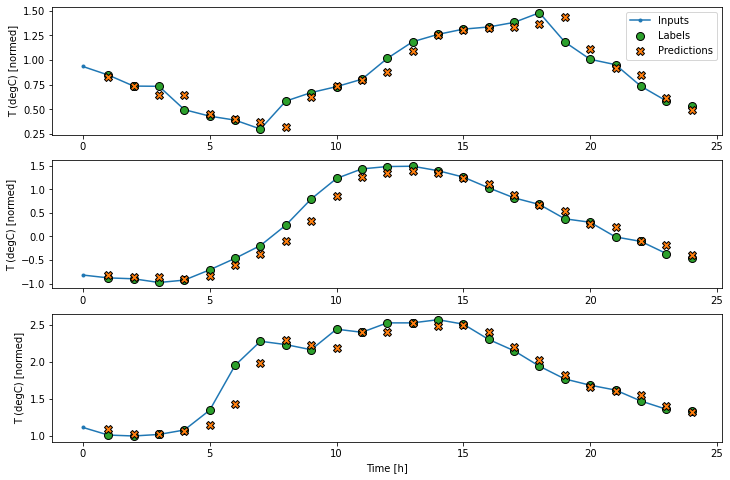

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights, and see the weight assigned to each input:

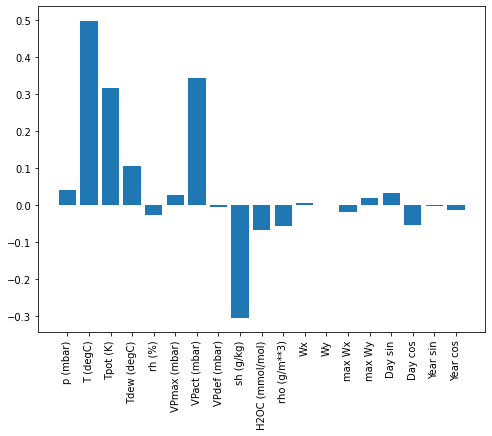

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization. 

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


   1/1534 [..............................] - ETA: 12:03 - loss: 3.2432 - mean_absolute_error: 1.4431

  15/1534 [..............................] - ETA: 5s - loss: 1.5238 - mean_absolute_error: 0.8745   

  31/1534 [..............................] - ETA: 5s - loss: 1.0669 - mean_absolute_error: 0.6909

  46/1534 [..............................] - ETA: 5s - loss: 0.8523 - mean_absolute_error: 0.5958

  61/1534 [>.............................] - ETA: 5s - loss: 0.7177 - mean_absolute_error: 0.5304

  76/1534 [>.............................] - ETA: 4s - loss: 0.6243 - mean_absolute_error: 0.4821

  91/1534 [>.............................] - ETA: 4s - loss: 0.5551 - mean_absolute_error: 0.4447

 107/1534 [=>............................] - ETA: 4s - loss: 0.4984 - mean_absolute_error: 0.4131

 122/1534 [=>............................] - ETA: 4s - loss: 0.4562 - mean_absolute_error: 0.3888

 137/1534 [=>............................] - ETA: 4s - loss: 0.4214 - mean_absolute_error: 0.3684

 153/1534 [=>............................] - ETA: 4s - loss: 0.3905 - mean_absolute_error: 0.3499

 169/1534 [==>...........................] - ETA: 4s - loss: 0.3644 - mean_absolute_error: 0.3339

 184/1534 [==>...........................] - ETA: 4s - loss: 0.3433 - mean_absolute_error: 0.3209

 199/1534 [==>...........................] - ETA: 4s - loss: 0.3249 - mean_absolute_error: 0.3093

 214/1534 [===>..........................] - ETA: 4s - loss: 0.3086 - mean_absolute_error: 0.2989

 229/1534 [===>..........................] - ETA: 4s - loss: 0.2941 - mean_absolute_error: 0.2896

 245/1534 [===>..........................] - ETA: 4s - loss: 0.2803 - mean_absolute_error: 0.2806

 260/1534 [====>.........................] - ETA: 4s - loss: 0.2686 - mean_absolute_error: 0.2729

 275/1534 [====>.........................] - ETA: 4s - loss: 0.2580 - mean_absolute_error: 0.2659

 291/1534 [====>.........................] - ETA: 4s - loss: 0.2478 - mean_absolute_error: 0.2591

 306/1534 [====>.........................] - ETA: 4s - loss: 0.2390 - mean_absolute_error: 0.2531

 321/1534 [=====>........................] - ETA: 4s - loss: 0.2309 - mean_absolute_error: 0.2477

 337/1534 [=====>........................] - ETA: 4s - loss: 0.2229 - mean_absolute_error: 0.2422

 352/1534 [=====>........................] - ETA: 3s - loss: 0.2160 - mean_absolute_error: 0.2375

 368/1534 [======>.......................] - ETA: 3s - loss: 0.2091 - mean_absolute_error: 0.2327

 383/1534 [======>.......................] - ETA: 3s - loss: 0.2032 - mean_absolute_error: 0.2286

 399/1534 [======>.......................] - ETA: 3s - loss: 0.1972 - mean_absolute_error: 0.2244

 414/1534 [=======>......................] - ETA: 3s - loss: 0.1920 - mean_absolute_error: 0.2207

 429/1534 [=======>......................] - ETA: 3s - loss: 0.1871 - mean_absolute_error: 0.2172

 444/1534 [=======>......................] - ETA: 3s - loss: 0.1824 - mean_absolute_error: 0.2139

 460/1534 [=======>......................] - ETA: 3s - loss: 0.1778 - mean_absolute_error: 0.2105

 475/1534 [========>.....................] - ETA: 3s - loss: 0.1737 - mean_absolute_error: 0.2076

 491/1534 [========>.....................] - ETA: 3s - loss: 0.1695 - mean_absolute_error: 0.2046

 507/1534 [========>.....................] - ETA: 3s - loss: 0.1656 - mean_absolute_error: 0.2017

 522/1534 [=========>....................] - ETA: 3s - loss: 0.1621 - mean_absolute_error: 0.1992

 537/1534 [=========>....................] - ETA: 3s - loss: 0.1588 - mean_absolute_error: 0.1967

 552/1534 [=========>....................] - ETA: 3s - loss: 0.1556 - mean_absolute_error: 0.1944

 568/1534 [==========>...................] - ETA: 3s - loss: 0.1524 - mean_absolute_error: 0.1920

 583/1534 [==========>...................] - ETA: 3s - loss: 0.1495 - mean_absolute_error: 0.1899

 599/1534 [==========>...................] - ETA: 3s - loss: 0.1466 - mean_absolute_error: 0.1877

 614/1534 [===========>..................] - ETA: 3s - loss: 0.1439 - mean_absolute_error: 0.1858

 630/1534 [===========>..................] - ETA: 3s - loss: 0.1413 - mean_absolute_error: 0.1837

 645/1534 [===========>..................] - ETA: 2s - loss: 0.1388 - mean_absolute_error: 0.1819

 660/1534 [===========>..................] - ETA: 2s - loss: 0.1365 - mean_absolute_error: 0.1802

 674/1534 [============>.................] - ETA: 2s - loss: 0.1344 - mean_absolute_error: 0.1786

 689/1534 [============>.................] - ETA: 2s - loss: 0.1323 - mean_absolute_error: 0.1769

 704/1534 [============>.................] - ETA: 2s - loss: 0.1302 - mean_absolute_error: 0.1754

 719/1534 [=============>................] - ETA: 2s - loss: 0.1282 - mean_absolute_error: 0.1738

 735/1534 [=============>................] - ETA: 2s - loss: 0.1262 - mean_absolute_error: 0.1722

 751/1534 [=============>................] - ETA: 2s - loss: 0.1242 - mean_absolute_error: 0.1707

 767/1534 [==============>...............] - ETA: 2s - loss: 0.1223 - mean_absolute_error: 0.1692

 782/1534 [==============>...............] - ETA: 2s - loss: 0.1206 - mean_absolute_error: 0.1679

 798/1534 [==============>...............] - ETA: 2s - loss: 0.1188 - mean_absolute_error: 0.1665

 814/1534 [==============>...............] - ETA: 2s - loss: 0.1171 - mean_absolute_error: 0.1652

 830/1534 [===============>..............] - ETA: 2s - loss: 0.1154 - mean_absolute_error: 0.1639

 845/1534 [===============>..............] - ETA: 2s - loss: 0.1139 - mean_absolute_error: 0.1627

 860/1534 [===============>..............] - ETA: 2s - loss: 0.1124 - mean_absolute_error: 0.1615

 875/1534 [================>.............] - ETA: 2s - loss: 0.1110 - mean_absolute_error: 0.1604

 890/1534 [================>.............] - ETA: 2s - loss: 0.1097 - mean_absolute_error: 0.1593

 905/1534 [================>.............] - ETA: 2s - loss: 0.1083 - mean_absolute_error: 0.1583

 920/1534 [================>.............] - ETA: 2s - loss: 0.1070 - mean_absolute_error: 0.1572

 935/1534 [=================>............] - ETA: 2s - loss: 0.1058 - mean_absolute_error: 0.1562

 950/1534 [=================>............] - ETA: 1s - loss: 0.1045 - mean_absolute_error: 0.1552

 965/1534 [=================>............] - ETA: 1s - loss: 0.1033 - mean_absolute_error: 0.1543

 980/1534 [==================>...........] - ETA: 1s - loss: 0.1022 - mean_absolute_error: 0.1534

 995/1534 [==================>...........] - ETA: 1s - loss: 0.1011 - mean_absolute_error: 0.1524

1010/1534 [==================>...........] - ETA: 1s - loss: 0.1000 - mean_absolute_error: 0.1516

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0989 - mean_absolute_error: 0.1507

1040/1534 [===================>..........] - ETA: 1s - loss: 0.0978 - mean_absolute_error: 0.1498

1055/1534 [===================>..........] - ETA: 1s - loss: 0.0968 - mean_absolute_error: 0.1490

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0958 - mean_absolute_error: 0.1482

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0948 - mean_absolute_error: 0.1474

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0939 - mean_absolute_error: 0.1466

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0929 - mean_absolute_error: 0.1459

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0920 - mean_absolute_error: 0.1451

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0911 - mean_absolute_error: 0.1443

1163/1534 [=====================>........] - ETA: 1s - loss: 0.0902 - mean_absolute_error: 0.1436

1179/1534 [======================>.......] - ETA: 1s - loss: 0.0893 - mean_absolute_error: 0.1429

1195/1534 [======================>.......] - ETA: 1s - loss: 0.0884 - mean_absolute_error: 0.1422

1210/1534 [======================>.......] - ETA: 1s - loss: 0.0876 - mean_absolute_error: 0.1415

1225/1534 [======================>.......] - ETA: 1s - loss: 0.0869 - mean_absolute_error: 0.1409

1241/1534 [=======================>......] - ETA: 0s - loss: 0.0860 - mean_absolute_error: 0.1402

1256/1534 [=======================>......] - ETA: 0s - loss: 0.0853 - mean_absolute_error: 0.1396

1271/1534 [=======================>......] - ETA: 0s - loss: 0.0846 - mean_absolute_error: 0.1390

1287/1534 [========================>.....] - ETA: 0s - loss: 0.0838 - mean_absolute_error: 0.1383

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0831 - mean_absolute_error: 0.1377

1318/1534 [========================>.....] - ETA: 0s - loss: 0.0824 - mean_absolute_error: 0.1371

1333/1534 [=========================>....] - ETA: 0s - loss: 0.0817 - mean_absolute_error: 0.1366

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0810 - mean_absolute_error: 0.1360

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0803 - mean_absolute_error: 0.1354

1381/1534 [==========================>...] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.1349

1396/1534 [==========================>...] - ETA: 0s - loss: 0.0790 - mean_absolute_error: 0.1343

1411/1534 [==========================>...] - ETA: 0s - loss: 0.0784 - mean_absolute_error: 0.1338

1426/1534 [==========================>...] - ETA: 0s - loss: 0.0778 - mean_absolute_error: 0.1333

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.1328

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0767 - mean_absolute_error: 0.1323

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0761 - mean_absolute_error: 0.1318

1487/1534 [============================>.] - ETA: 0s - loss: 0.0755 - mean_absolute_error: 0.1314

1502/1534 [============================>.] - ETA: 0s - loss: 0.0750 - mean_absolute_error: 0.1309

1518/1534 [============================>.] - ETA: 0s - loss: 0.0744 - mean_absolute_error: 0.1304

1533/1534 [============================>.] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.1300

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0738 - mean_absolute_error: 0.1299 - val_loss: 0.0084 - val_mean_absolute_error: 0.0676


Epoch 2/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0078 - mean_absolute_error: 0.0644

  16/1534 [..............................] - ETA: 5s - loss: 0.0091 - mean_absolute_error: 0.0718 

  31/1534 [..............................] - ETA: 5s - loss: 0.0088 - mean_absolute_error: 0.0704

  47/1534 [..............................] - ETA: 5s - loss: 0.0087 - mean_absolute_error: 0.0696

  63/1534 [>.............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0688

  78/1534 [>.............................] - ETA: 4s - loss: 0.0085 - mean_absolute_error: 0.0685

  93/1534 [>.............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0682

 108/1534 [=>............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0680

 123/1534 [=>............................] - ETA: 4s - loss: 0.0084 - mean_absolute_error: 0.0679

 138/1534 [=>............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0678

 153/1534 [=>............................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0677

 168/1534 [==>...........................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0675

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0083 - mean_absolute_error: 0.0673

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0672

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0671

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0670

 246/1534 [===>..........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0669

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0669

 277/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0669

 293/1534 [====>.........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0668

 308/1534 [=====>........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0668

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0668

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0082 - mean_absolute_error: 0.0668

 354/1534 [=====>........................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0668

 370/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0667

 385/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0667

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0082 - mean_absolute_error: 0.0667

 415/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0666

 430/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0666

 445/1534 [=======>......................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0666

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 477/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 493/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 508/1534 [========>.....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0665

 523/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 538/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 553/1534 [=========>....................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 568/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0664

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0663

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0663

 641/1534 [===========>..................] - ETA: 3s - loss: 0.0081 - mean_absolute_error: 0.0663

 656/1534 [===========>..................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0663

 671/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0663

 686/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0662

 699/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0662

 714/1534 [============>.................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0662

 729/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0662

 744/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0662

 759/1534 [=============>................] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0661

 774/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0661

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0661

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0661

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0660

 835/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0660

 850/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0660

 865/1534 [===============>..............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0660

 879/1534 [================>.............] - ETA: 2s - loss: 0.0081 - mean_absolute_error: 0.0660

 894/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0660

 910/1534 [================>.............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0659

 925/1534 [=================>............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0659

 941/1534 [=================>............] - ETA: 2s - loss: 0.0080 - mean_absolute_error: 0.0659

 957/1534 [=================>............] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0659

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0659

 987/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0659

1002/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1017/1534 [==================>...........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1032/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1062/1534 [===================>..........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1077/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1093/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0658

1108/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1138/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1199/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1215/1534 [======================>.......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1231/1534 [=======================>......] - ETA: 1s - loss: 0.0080 - mean_absolute_error: 0.0657

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1308/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1398/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1413/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1428/1534 [==========================>...] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0656

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0655

1491/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0655

1506/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0655

1521/1534 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0655

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0080 - mean_absolute_error: 0.0655 - val_loss: 0.0076 - val_mean_absolute_error: 0.0634


Epoch 3/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0043 - mean_absolute_error: 0.0477

  16/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0614 

  32/1534 [..............................] - ETA: 5s - loss: 0.0074 - mean_absolute_error: 0.0629

  47/1534 [..............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

  62/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

  77/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

  93/1534 [>.............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0633

 109/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

 125/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

 140/1534 [=>............................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

 155/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0631

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 185/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 200/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 215/1534 [===>..........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 276/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0629

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 308/1534 [=====>........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 324/1534 [=====>........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0631

 340/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 372/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 403/1534 [======>.......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 419/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 446/1534 [=======>......................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 461/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 476/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 491/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 506/1534 [========>.....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 521/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 536/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 551/1534 [=========>....................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 581/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 596/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 626/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0075 - mean_absolute_error: 0.0631

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 673/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 689/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 704/1534 [============>.................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 719/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 734/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 750/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 765/1534 [=============>................] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 810/1534 [==============>...............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 841/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 872/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 887/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 902/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 918/1534 [================>.............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 933/1534 [=================>............] - ETA: 2s - loss: 0.0075 - mean_absolute_error: 0.0631

 949/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

 964/1534 [=================>............] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

 995/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1010/1534 [==================>...........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1025/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1087/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1102/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1117/1534 [====================>.........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1132/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1147/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1162/1534 [=====================>........] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1178/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1193/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1223/1534 [======================>.......] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0631

1238/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1253/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1268/1534 [=======================>......] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1283/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1298/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1313/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1328/1534 [========================>.....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1343/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1358/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1373/1534 [=========================>....] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1388/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1404/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1419/1534 [==========================>...] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1434/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1449/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1465/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1481/1534 [===========================>..] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1496/1534 [============================>.] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0631

1511/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1526/1534 [============================>.] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.0631

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0631 - val_loss: 0.0074 - val_mean_absolute_error: 0.0618


Epoch 4/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0063 - mean_absolute_error: 0.0621

  16/1534 [..............................] - ETA: 5s - loss: 0.0078 - mean_absolute_error: 0.0660 

  31/1534 [..............................] - ETA: 5s - loss: 0.0077 - mean_absolute_error: 0.0645

  47/1534 [..............................] - ETA: 5s - loss: 0.0075 - mean_absolute_error: 0.0635

  62/1534 [>.............................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

  77/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0623

  92/1534 [>.............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 107/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 122/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 137/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 152/1534 [=>............................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 167/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 197/1534 [==>...........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 212/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 227/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 242/1534 [===>..........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 258/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 273/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 289/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 305/1534 [====>.........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 320/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0619

 335/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0620

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 379/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 425/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 440/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 471/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 548/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 563/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 658/1534 [===========>..................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0617

 673/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 689/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 704/1534 [============>.................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 719/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 734/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 750/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 764/1534 [=============>................] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 779/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0616

 794/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 810/1534 [==============>...............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 825/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 840/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 856/1534 [===============>..............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 871/1534 [================>.............] - ETA: 2s - loss: 0.0073 - mean_absolute_error: 0.0615

 887/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0615

 903/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0615

 918/1534 [================>.............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0615

 934/1534 [=================>............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0615

 950/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

 966/1534 [=================>............] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

 979/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

 994/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1009/1534 [==================>...........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1023/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0615

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1084/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1099/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1114/1534 [====================>.........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1130/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1176/1534 [=====================>........] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1208/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1223/1534 [======================>.......] - ETA: 1s - loss: 0.0072 - mean_absolute_error: 0.0614

1239/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1254/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1269/1534 [=======================>......] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1284/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1300/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1315/1534 [========================>.....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1330/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1345/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1360/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1375/1534 [=========================>....] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1390/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1406/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1422/1534 [==========================>...] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1438/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1453/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1484/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1499/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1514/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1527/1534 [============================>.] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0614

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0072 - mean_absolute_error: 0.0614 - val_loss: 0.0076 - val_mean_absolute_error: 0.0634


Epoch 5/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0118 - mean_absolute_error: 0.0787

  16/1534 [..............................] - ETA: 5s - loss: 0.0090 - mean_absolute_error: 0.0693 

  32/1534 [..............................] - ETA: 5s - loss: 0.0086 - mean_absolute_error: 0.0681

  47/1534 [..............................] - ETA: 5s - loss: 0.0083 - mean_absolute_error: 0.0670

  62/1534 [>.............................] - ETA: 4s - loss: 0.0081 - mean_absolute_error: 0.0661

  78/1534 [>.............................] - ETA: 4s - loss: 0.0080 - mean_absolute_error: 0.0653

  94/1534 [>.............................] - ETA: 4s - loss: 0.0079 - mean_absolute_error: 0.0648

 110/1534 [=>............................] - ETA: 4s - loss: 0.0078 - mean_absolute_error: 0.0645

 126/1534 [=>............................] - ETA: 4s - loss: 0.0077 - mean_absolute_error: 0.0642

 141/1534 [=>............................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0639

 157/1534 [==>...........................] - ETA: 4s - loss: 0.0076 - mean_absolute_error: 0.0637

 173/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0634

 188/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0632

 204/1534 [==>...........................] - ETA: 4s - loss: 0.0075 - mean_absolute_error: 0.0630

 219/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0629

 235/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0628

 251/1534 [===>..........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 267/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0626

 283/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0625

 298/1534 [====>.........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 313/1534 [=====>........................] - ETA: 4s - loss: 0.0074 - mean_absolute_error: 0.0624

 328/1534 [=====>........................] - ETA: 4s - loss: 0.0073 - mean_absolute_error: 0.0623

 344/1534 [=====>........................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0623

 360/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0622

 375/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0622

 390/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 405/1534 [======>.......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0621

 421/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 434/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0620

 449/1534 [=======>......................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 464/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0619

 480/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 495/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 510/1534 [========>.....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0618

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0073 - mean_absolute_error: 0.0617

 541/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0617

 557/1534 [=========>....................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0616

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0616

 588/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0616

 603/1534 [==========>...................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0615

 618/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0615

 633/1534 [===========>..................] - ETA: 3s - loss: 0.0072 - mean_absolute_error: 0.0615

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 663/1534 [===========>..................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 678/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0614

 694/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 709/1534 [============>.................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 725/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0613

 740/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 755/1534 [=============>................] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 770/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0612

 785/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 801/1534 [==============>...............] - ETA: 2s - loss: 0.0072 - mean_absolute_error: 0.0611

 816/1534 [==============>...............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0611

 832/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0611

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 879/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 894/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 909/1534 [================>.............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0610

 924/1534 [=================>............] - ETA: 2s - loss: 0.0071 - mean_absolute_error: 0.0609

 940/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

 956/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

 971/1534 [=================>............] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

 986/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

1001/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0609

1016/1534 [==================>...........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1031/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1047/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1063/1534 [===================>..........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1078/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1125/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1140/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0608

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1171/1534 [=====================>........] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1187/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1203/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1219/1534 [======================>.......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1235/1534 [=======================>......] - ETA: 1s - loss: 0.0071 - mean_absolute_error: 0.0607

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1266/1534 [=======================>......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1281/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1312/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1327/1534 [========================>.....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1342/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1357/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1372/1534 [=========================>....] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1387/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1415/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1430/1534 [==========================>...] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1446/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1461/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

1493/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1508/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1524/1534 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0606 - val_loss: 0.0072 - val_mean_absolute_error: 0.0614


Epoch 6/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0092 - mean_absolute_error: 0.0727

  16/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0610 

  31/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0612

  47/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0612

  62/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0608

  77/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

  93/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 109/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 122/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 137/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 150/1534 [=>............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 165/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 181/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0607

 196/1534 [==>...........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 211/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 227/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

 242/1534 [===>..........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 257/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0605

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 317/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 332/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 347/1534 [=====>........................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0604

 363/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 378/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 393/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0603

 409/1534 [======>.......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0602

 424/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0602

 439/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0602

 455/1534 [=======>......................] - ETA: 3s - loss: 0.0070 - mean_absolute_error: 0.0602

 470/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0602

 486/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 502/1534 [========>.....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 533/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 548/1534 [=========>....................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0601

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 595/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 611/1534 [==========>...................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 642/1534 [===========>..................] - ETA: 3s - loss: 0.0069 - mean_absolute_error: 0.0600

 657/1534 [===========>..................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0600

 673/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0600

 689/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 704/1534 [============>.................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 719/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 734/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 750/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 765/1534 [=============>................] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 780/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 795/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0599

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 827/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 843/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 858/1534 [===============>..............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 873/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 889/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 904/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 919/1534 [================>.............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 934/1534 [=================>............] - ETA: 2s - loss: 0.0069 - mean_absolute_error: 0.0598

 950/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0598

 965/1534 [=================>............] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0598

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0598

 997/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0598

1012/1534 [==================>...........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1027/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1088/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1104/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1151/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1166/1534 [=====================>........] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1197/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1213/1534 [======================>.......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1228/1534 [=======================>......] - ETA: 1s - loss: 0.0069 - mean_absolute_error: 0.0597

1243/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1258/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1274/1534 [=======================>......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1289/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1304/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1334/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1349/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1364/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1379/1534 [=========================>....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1394/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1440/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1455/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1470/1534 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1485/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1500/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1515/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0597

1532/1534 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0598 - val_loss: 0.0077 - val_mean_absolute_error: 0.0641


Epoch 7/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0065 - mean_absolute_error: 0.0654

  16/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0631 

  31/1534 [..............................] - ETA: 5s - loss: 0.0073 - mean_absolute_error: 0.0628

  46/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0619

  62/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0611

  77/1534 [>.............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0606

  92/1534 [>.............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0603

 107/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0601

 122/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0599

 137/1534 [=>............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0597

 153/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0596

 168/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0595

 183/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0594

 198/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 213/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 229/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 260/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 275/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 290/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 305/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 320/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 335/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 366/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 381/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 396/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 411/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 427/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 488/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 549/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 564/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 579/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 594/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 609/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 624/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 639/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0591

 654/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 669/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 684/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 699/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 715/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 730/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 745/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 760/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 775/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 790/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 806/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 822/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 838/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 853/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 868/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 883/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 898/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 913/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 929/1534 [=================>............] - ETA: 2s - loss: 0.0067 - mean_absolute_error: 0.0589

 944/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

 960/1534 [=================>............] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

 976/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

 992/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1007/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1022/1534 [==================>...........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1038/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1053/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1068/1534 [===================>..........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1083/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1098/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1113/1534 [====================>.........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1128/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1143/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1159/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1174/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1190/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1205/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1220/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1235/1534 [=======================>......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1250/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1265/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1280/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1295/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1310/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1325/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1340/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1400/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1416/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1431/1534 [==========================>...] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1447/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1462/1534 [===========================>..] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1477/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1492/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1507/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1522/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0588 - val_loss: 0.0066 - val_mean_absolute_error: 0.0569


Epoch 8/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0092 - mean_absolute_error: 0.0723

  16/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0597 

  31/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0599

  47/1534 [..............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0597

  62/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0592

  77/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0590

  93/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 109/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 124/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0590

 139/1534 [=>............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 245/1534 [===>..........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 260/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0591

 275/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 290/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 305/1534 [====>.........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0592

 320/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 335/1534 [=====>........................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0593

 350/1534 [=====>........................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 365/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 380/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 395/1534 [======>.......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 410/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 426/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 442/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 457/1534 [=======>......................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 472/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 487/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 503/1534 [========>.....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0593

 518/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 534/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 550/1534 [=========>....................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 566/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 582/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 597/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 612/1534 [==========>...................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 627/1534 [===========>..................] - ETA: 3s - loss: 0.0068 - mean_absolute_error: 0.0592

 643/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 659/1534 [===========>..................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 675/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0592

 690/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 705/1534 [============>.................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 720/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 736/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 751/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 766/1534 [=============>................] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0591

 781/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 796/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 811/1534 [==============>...............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 826/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 842/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 857/1534 [===============>..............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 872/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 888/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 904/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0590

 920/1534 [================>.............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 935/1534 [=================>............] - ETA: 2s - loss: 0.0068 - mean_absolute_error: 0.0589

 950/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

 965/1534 [=================>............] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

 981/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

 996/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1011/1534 [==================>...........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1026/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1041/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1056/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1071/1534 [===================>..........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1086/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1101/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1116/1534 [====================>.........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1131/1534 [=====================>........] - ETA: 1s - loss: 0.0068 - mean_absolute_error: 0.0589

1146/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1161/1534 [=====================>........] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0589

1177/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1192/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1207/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1222/1534 [======================>.......] - ETA: 1s - loss: 0.0067 - mean_absolute_error: 0.0588

1237/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1252/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1267/1534 [=======================>......] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1282/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1296/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1311/1534 [========================>.....] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0588

1326/1534 [========================>.....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1341/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1355/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1385/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1454/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1468/1534 [===========================>..] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1483/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1498/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1513/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1529/1534 [============================>.] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0588

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0588 - val_loss: 0.0065 - val_mean_absolute_error: 0.0568


Epoch 9/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0051 - mean_absolute_error: 0.0533

  16/1534 [..............................] - ETA: 5s - loss: 0.0065 - mean_absolute_error: 0.0592 

  32/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0591

  47/1534 [..............................] - ETA: 5s - loss: 0.0066 - mean_absolute_error: 0.0587

  62/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

  77/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

  92/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 107/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 122/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 137/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0586

 152/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 167/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 182/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 197/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 212/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 227/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 242/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 257/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 272/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 287/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 302/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 317/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 332/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0585

 347/1534 [=====>........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0586

 362/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 377/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 392/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0586

 407/1534 [======>.......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 422/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 437/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 452/1534 [=======>......................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 468/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 484/1534 [========>.....................] - ETA: 3s - loss: 0.0067 - mean_absolute_error: 0.0585

 499/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0585

 514/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 529/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 544/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 559/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 573/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 589/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 604/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 619/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0584

 634/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0583

 649/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 665/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 681/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 697/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 713/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 728/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 743/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0583

 758/1534 [=============>................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 773/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 789/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 805/1534 [==============>...............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 820/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 836/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 852/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 867/1534 [===============>..............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 882/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 897/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 912/1534 [================>.............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 927/1534 [=================>............] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0582

 942/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0582

 957/1534 [=================>............] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0582

 972/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

 988/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1003/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1019/1534 [==================>...........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1034/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1049/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1064/1534 [===================>..........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1079/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1094/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1109/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1124/1534 [====================>.........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1153/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1168/1534 [=====================>........] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1183/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1214/1534 [======================>.......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0066 - mean_absolute_error: 0.0581

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1260/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1306/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1322/1534 [========================>.....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1337/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1352/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1367/1534 [=========================>....] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1382/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1397/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1412/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1427/1534 [==========================>...] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1442/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1457/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1487/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1503/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1518/1534 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0581

1534/1534 [==============================] - 7s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0581 - val_loss: 0.0067 - val_mean_absolute_error: 0.0583


Epoch 10/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0052 - mean_absolute_error: 0.0494

  17/1534 [..............................] - ETA: 4s - loss: 0.0072 - mean_absolute_error: 0.0602 

  33/1534 [..............................] - ETA: 4s - loss: 0.0070 - mean_absolute_error: 0.0594

  48/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0586

  64/1534 [>.............................] - ETA: 4s - loss: 0.0068 - mean_absolute_error: 0.0581

  79/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0579

  94/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0578

 110/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0578

 125/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0578

 141/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0578

 156/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0578

 172/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0578

 187/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 202/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 232/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 248/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 279/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 294/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 309/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 325/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 340/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 372/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 402/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 570/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 585/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 600/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 616/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 632/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0575

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 660/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 676/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 691/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 706/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 721/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 736/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 752/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 799/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 814/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 830/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 846/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 877/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 892/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 908/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 923/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 939/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 955/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 970/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 999/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1014/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1029/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1044/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1059/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1075/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1107/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1123/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1139/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1155/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1170/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1185/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1200/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1216/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1231/1534 [=======================>......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1247/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1263/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1278/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1293/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1309/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1324/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1339/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1354/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1370/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1386/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1402/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1417/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1433/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1448/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1463/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1479/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1494/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1509/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1524/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0574

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0574 - val_loss: 0.0064 - val_mean_absolute_error: 0.0563


Epoch 11/20
   1/1534 [..............................] - ETA: 28s - loss: 0.0087 - mean_absolute_error: 0.0647

  16/1534 [..............................] - ETA: 5s - loss: 0.0072 - mean_absolute_error: 0.0591 

  31/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0584

  47/1534 [..............................] - ETA: 4s - loss: 0.0069 - mean_absolute_error: 0.0579

  63/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0574

  78/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

  93/1534 [>.............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0572

 109/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 124/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0573

 139/1534 [=>............................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0574

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0575

 170/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0575

 186/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0575

 201/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 217/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 233/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 249/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 264/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 280/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0576

 295/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 310/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 326/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0577

 341/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 356/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 371/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 387/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 402/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 418/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 433/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 448/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0577

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 525/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 555/1534 [=========>....................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 571/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 587/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0576

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 632/1534 [===========>..................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0575

 648/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 664/1534 [===========>..................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 680/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 695/1534 [============>.................] - ETA: 2s - loss: 0.0066 - mean_absolute_error: 0.0575

 711/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 726/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 741/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 756/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 772/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 788/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 803/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 818/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 833/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 848/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 863/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 878/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 893/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 908/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 923/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0573

 939/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 954/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 969/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

 985/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1000/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1015/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1030/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1046/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1061/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1076/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1091/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1106/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1121/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1136/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1152/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1167/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1182/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1198/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1214/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1230/1534 [=======================>......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0572

1245/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1261/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1276/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1291/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1307/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1323/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1338/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1353/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1368/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1383/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1399/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1414/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1429/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1444/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1460/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1476/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1492/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1507/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1522/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0572

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0572 - val_loss: 0.0071 - val_mean_absolute_error: 0.0607


Epoch 12/20
   1/1534 [..............................] - ETA: 29s - loss: 0.0105 - mean_absolute_error: 0.0742

  16/1534 [..............................] - ETA: 5s - loss: 0.0071 - mean_absolute_error: 0.0622 

  32/1534 [..............................] - ETA: 5s - loss: 0.0070 - mean_absolute_error: 0.0611

  45/1534 [..............................] - ETA: 5s - loss: 0.0069 - mean_absolute_error: 0.0603

  60/1534 [>.............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0596

  75/1534 [>.............................] - ETA: 5s - loss: 0.0068 - mean_absolute_error: 0.0593

  91/1534 [>.............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0591

 106/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0590

 122/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0589

 138/1534 [=>............................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0588

 154/1534 [==>...........................] - ETA: 4s - loss: 0.0067 - mean_absolute_error: 0.0587

 169/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0586

 184/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 199/1534 [==>...........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0585

 214/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0584

 230/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 246/1534 [===>..........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0583

 261/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 277/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 292/1534 [====>.........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 307/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 323/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 338/1534 [=====>........................] - ETA: 4s - loss: 0.0066 - mean_absolute_error: 0.0582

 353/1534 [=====>........................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 368/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 384/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 400/1534 [======>.......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0581

 416/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 432/1534 [=======>......................] - ETA: 3s - loss: 0.0066 - mean_absolute_error: 0.0580

 447/1534 [=======>......................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0580

 463/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 479/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 494/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0579

 509/1534 [========>.....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 524/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 540/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 556/1534 [=========>....................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 572/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0578

 587/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 602/1534 [==========>...................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 617/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 632/1534 [===========>..................] - ETA: 3s - loss: 0.0065 - mean_absolute_error: 0.0577

 647/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 662/1534 [===========>..................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0577

 678/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 693/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 708/1534 [============>.................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 723/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 738/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0576

 753/1534 [=============>................] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 768/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 783/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 798/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 813/1534 [==============>...............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 829/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0575

 845/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 861/1534 [===============>..............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 876/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 891/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 906/1534 [================>.............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 922/1534 [=================>............] - ETA: 2s - loss: 0.0065 - mean_absolute_error: 0.0574

 938/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 953/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 968/1534 [=================>............] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 983/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

 998/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1013/1534 [==================>...........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0574

1028/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1043/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1058/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1073/1534 [===================>..........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1089/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1105/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1120/1534 [====================>.........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1133/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1149/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1165/1534 [=====================>........] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1181/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1196/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1211/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1227/1534 [======================>.......] - ETA: 1s - loss: 0.0065 - mean_absolute_error: 0.0573

1242/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1257/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1273/1534 [=======================>......] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1288/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1303/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1319/1534 [========================>.....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1335/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1350/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1365/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1380/1534 [=========================>....] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1395/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1410/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1425/1534 [==========================>...] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1441/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1456/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1472/1534 [===========================>..] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1487/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1502/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1518/1534 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1534/1534 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0573

1534/1534 [==============================] - 6s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0573 - val_loss: 0.0070 - val_mean_absolute_error: 0.0601


  1/439 [..............................] - ETA: 23s - loss: 0.0112 - mean_absolute_error: 0.0713

 19/439 [>.............................] - ETA: 1s - loss: 0.0083 - mean_absolute_error: 0.0638 

 37/439 [=>............................] - ETA: 1s - loss: 0.0078 - mean_absolute_error: 0.0627

 55/439 [==>...........................] - ETA: 1s - loss: 0.0076 - mean_absolute_error: 0.0620

 73/439 [===>..........................] - ETA: 1s - loss: 0.0077 - mean_absolute_error: 0.0624

 91/439 [=====>........................] - ETA: 1s - loss: 0.0075 - mean_absolute_error: 0.0623

109/439 [======>.......................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0615

126/439 [=======>......................] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.0619

144/439 [========>.....................] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0615

162/439 [==========>...................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0612

180/439 [===========>..................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0610

198/439 [============>.................] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

216/439 [=============>................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0611

234/439 [==============>...............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

251/439 [================>.............] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0610

269/439 [=================>............] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0607

287/439 [==================>...........] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0608

305/439 [===================>..........] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

323/439 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0604

341/439 [======================>.......] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0603

359/439 [=======================>......] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

377/439 [========================>.....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

395/439 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0599

413/439 [===========================>..] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

431/439 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0601

439/439 [==============================] - 1s 3ms/step - loss: 0.0070 - mean_absolute_error: 0.0601


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](images/conv_window.png)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of the 3h of inputs and, 1h of labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

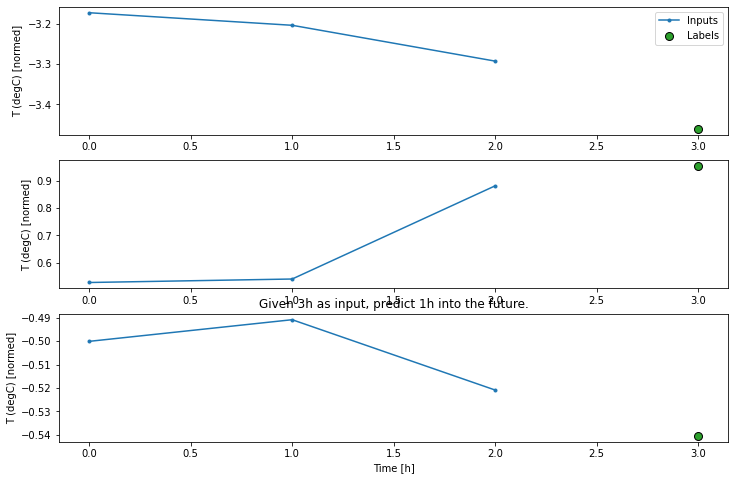

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 22s - loss: 0.0077 - mean_absolute_error: 0.0671

 24/438 [>.............................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0592 

 46/438 [==>...........................] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0591

 69/438 [===>..........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0594

 92/438 [=====>........................] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0597

115/438 [======>.......................] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0603

138/438 [========>.....................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0606

161/438 [==========>...................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0607

184/438 [===========>..................] - ETA: 0s - loss: 0.0073 - mean_absolute_error: 0.0609

207/438 [=============>................] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

230/438 [==============>...............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

253/438 [================>.............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0605

276/438 [=================>............] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0604

299/438 [===================>..........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

322/438 [=====================>........] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0602

345/438 [======================>.......] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0601

368/438 [========================>.....] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0600

391/438 [=========================>....] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0600

414/438 [===========================>..] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0599

435/438 [============================>.] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0598

438/438 [==============================] - 1s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0598


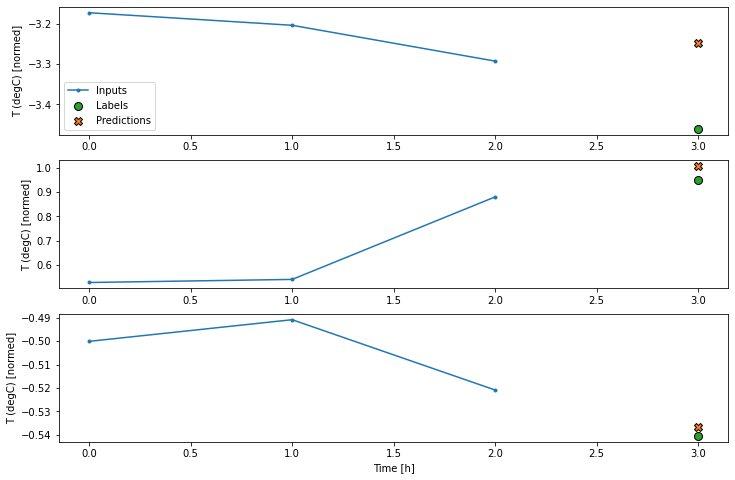

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Input 0 of layer dense_4 is incompatible with the layer: expected axis -1 of input shape to have value 57 but received input with shape (32, 456)


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `layers.Flatten` and the first `layers.Dense` are replaced by a `layers.Conv1D`.
* The `layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to see that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

  1/438 [..............................] - ETA: 23s - loss: 0.0028 - mean_absolute_error: 0.0412

 18/438 [>.............................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0510 

 36/438 [=>............................] - ETA: 1s - loss: 0.0060 - mean_absolute_error: 0.0517

 54/438 [==>...........................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0518

 71/438 [===>..........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0519

 89/438 [=====>........................] - ETA: 1s - loss: 0.0058 - mean_absolute_error: 0.0521

107/438 [======>.......................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0527

125/438 [=======>......................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0526

143/438 [========>.....................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0528

161/438 [==========>...................] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0533

179/438 [===========>..................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0534

197/438 [============>.................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0533

215/438 [=============>................] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0535

233/438 [==============>...............] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0532

251/438 [================>.............] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0535

269/438 [=================>............] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0533

287/438 [==================>...........] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0536

305/438 [===================>..........] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0541

323/438 [=====================>........] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0540

341/438 [======================>.......] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0540

359/438 [=======================>......] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0539

375/438 [========================>.....] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0539

393/438 [=========================>....] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0538

411/438 [===========================>..] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0539

429/438 [============================>.] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0539

438/438 [==============================] - 1s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0539


The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](images/wide_conv_window.png)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:

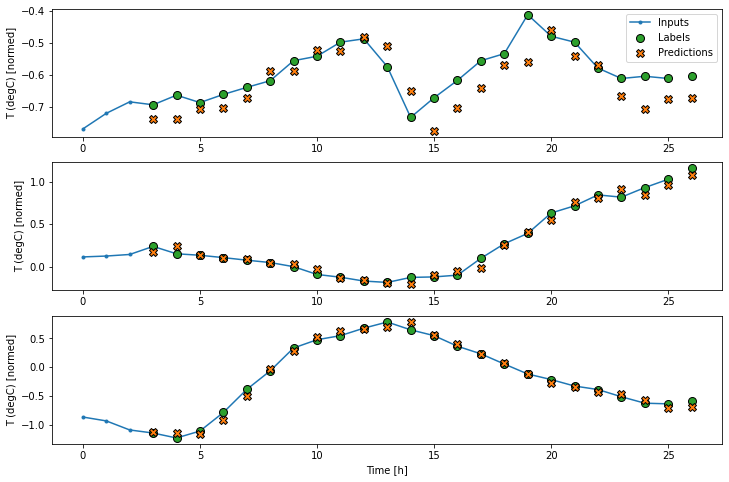

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

For more details, read the [text generation tutorial](https://www.tensorflow.org/tutorials/text/text_generation) or the [RNN guide](https://www.tensorflow.org/guide/keras/rnn). 

In this tutorial, you will use an RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

An important constructor argument for all keras RNN layers is the `return_sequences` argument. This setting can configure the layer in one of two ways.

1. If `False`, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction: 

![An lstm warming up and making a single prediction](images/lstm_1_window.png)

2. If `True` the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple timesteps simultaneously.

![An lstm making a prediction after every timestep](images/lstm_many_window.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True` the model can be trained on 24h of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first timestep the model has no access to previous steps, and so can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)


Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 26s - loss: 0.0065 - mean_absolute_error: 0.0534

 16/438 [>.............................] - ETA: 1s - loss: 0.0054 - mean_absolute_error: 0.0506 

 31/438 [=>............................] - ETA: 1s - loss: 0.0055 - mean_absolute_error: 0.0506

 47/438 [==>...........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0512

 62/438 [===>..........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0513

 78/438 [====>.........................] - ETA: 1s - loss: 0.0057 - mean_absolute_error: 0.0511

 93/438 [=====>........................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0511

108/438 [======>.......................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0511

123/438 [=======>......................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0510

138/438 [========>.....................] - ETA: 1s - loss: 0.0056 - mean_absolute_error: 0.0509

153/438 [=========>....................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

168/438 [==========>...................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

183/438 [===========>..................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

198/438 [============>.................] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0508

213/438 [=============>................] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

228/438 [==============>...............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

243/438 [===============>..............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

258/438 [================>.............] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

273/438 [=================>............] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

288/438 [==================>...........] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

303/438 [===================>..........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

319/438 [====================>.........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

334/438 [=====================>........] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

349/438 [======================>.......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0510

364/438 [=======================>......] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

379/438 [========================>.....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

394/438 [=========================>....] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0509

410/438 [===========================>..] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0509

425/438 [============================>.] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0510

438/438 [==============================] - 2s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0510


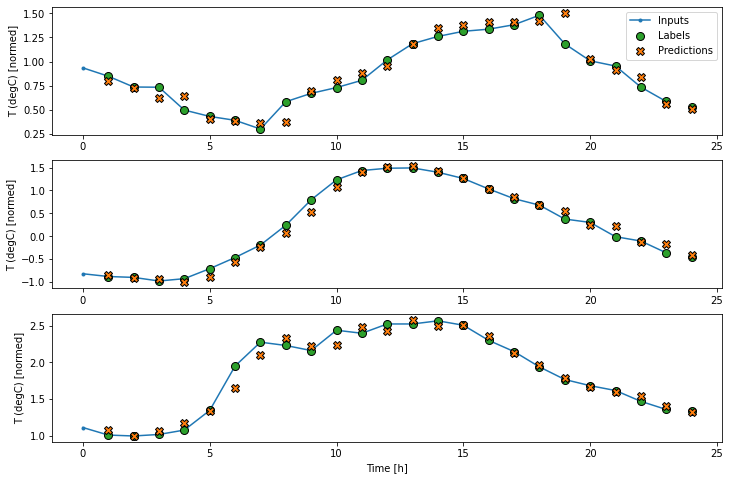

In [ ]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it.

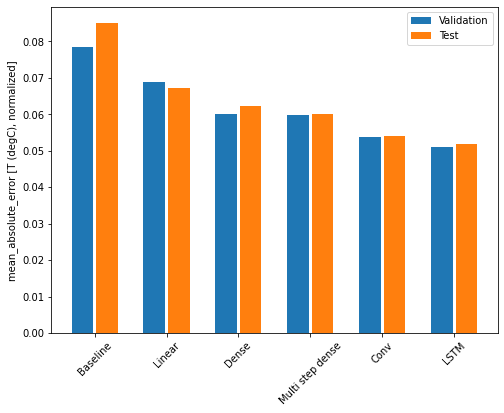

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0672
Dense       : 0.0622
Multi step dense: 0.0601
Conv        : 0.0542
LSTM        : 0.0519


### Multi-output models

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels`.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of 1.

#### Baseline

The same baseline model can be used here, but this time repeating all features instead of selecting a specific `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

  1/438 [..............................] - ETA: 47s - loss: 0.0830 - mean_absolute_error: 0.1483

 23/438 [>.............................] - ETA: 0s - loss: 0.0837 - mean_absolute_error: 0.1534 

 46/438 [==>...........................] - ETA: 0s - loss: 0.0860 - mean_absolute_error: 0.1558

 69/438 [===>..........................] - ETA: 0s - loss: 0.0866 - mean_absolute_error: 0.1566

 91/438 [=====>........................] - ETA: 0s - loss: 0.0869 - mean_absolute_error: 0.1569

114/438 [======>.......................] - ETA: 0s - loss: 0.0872 - mean_absolute_error: 0.1572

137/438 [========>.....................] - ETA: 0s - loss: 0.0875 - mean_absolute_error: 0.1574

160/438 [=========>....................] - ETA: 0s - loss: 0.0876 - mean_absolute_error: 0.1576

183/438 [===========>..................] - ETA: 0s - loss: 0.0877 - mean_absolute_error: 0.1577

206/438 [=============>................] - ETA: 0s - loss: 0.0878 - mean_absolute_error: 0.1578

230/438 [==============>...............] - ETA: 0s - loss: 0.0879 - mean_absolute_error: 0.1579

252/438 [================>.............] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1580

275/438 [=================>............] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.1581

298/438 [===================>..........] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.1581

321/438 [====================>.........] - ETA: 0s - loss: 0.0881 - mean_absolute_error: 0.1582

344/438 [======================>.......] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1583

367/438 [========================>.....] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1583

390/438 [=========================>....] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1583

413/438 [===========================>..] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1584

437/438 [============================>.] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.1584

438/438 [==============================] - 1s 2ms/step - loss: 0.0882 - mean_absolute_error: 0.1584


#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

  1/439 [..............................] - ETA: 22s - loss: 0.0539 - mean_absolute_error: 0.1172

 18/439 [>.............................] - ETA: 1s - loss: 0.0695 - mean_absolute_error: 0.1313 

 36/439 [=>............................] - ETA: 1s - loss: 0.0653 - mean_absolute_error: 0.1271

 53/439 [==>...........................] - ETA: 1s - loss: 0.0666 - mean_absolute_error: 0.1276

 70/439 [===>..........................] - ETA: 1s - loss: 0.0679 - mean_absolute_error: 0.1286

 87/439 [====>.........................] - ETA: 1s - loss: 0.0668 - mean_absolute_error: 0.1279

104/439 [======>.......................] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1284

121/439 [=======>......................] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1280

138/439 [========>.....................] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1281

155/439 [=========>....................] - ETA: 0s - loss: 0.0677 - mean_absolute_error: 0.1281

172/439 [==========>...................] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1280

189/439 [===========>..................] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1282

204/439 [============>.................] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1284

221/439 [==============>...............] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1284

238/439 [===============>..............] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.1283

255/439 [================>.............] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1286

270/439 [=================>............] - ETA: 0s - loss: 0.0683 - mean_absolute_error: 0.1288

287/439 [==================>...........] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1285

304/439 [===================>..........] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1287

321/439 [====================>.........] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1285

339/439 [======================>.......] - ETA: 0s - loss: 0.0678 - mean_absolute_error: 0.1284

357/439 [=======================>......] - ETA: 0s - loss: 0.0681 - mean_absolute_error: 0.1285

374/439 [========================>.....] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.1287

391/439 [=========================>....] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.1286

408/439 [==========================>...] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.1284

425/439 [============================>.] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.1282

439/439 [==============================] - 1s 3ms/step - loss: 0.0675 - mean_absolute_error: 0.1281


#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

  1/438 [..............................] - ETA: 22s - loss: 0.0650 - mean_absolute_error: 0.1210

 16/438 [>.............................] - ETA: 1s - loss: 0.0603 - mean_absolute_error: 0.1201 

 32/438 [=>............................] - ETA: 1s - loss: 0.0608 - mean_absolute_error: 0.1206

 48/438 [==>...........................] - ETA: 1s - loss: 0.0601 - mean_absolute_error: 0.1200

 64/438 [===>..........................] - ETA: 1s - loss: 0.0610 - mean_absolute_error: 0.1207

 79/438 [====>.........................] - ETA: 1s - loss: 0.0611 - mean_absolute_error: 0.1208

 94/438 [=====>........................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1209

110/438 [======>.......................] - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.1209

126/438 [=======>......................] - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.1210

142/438 [========>.....................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1206

158/438 [=========>....................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1207

173/438 [==========>...................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1207

189/438 [===========>..................] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1207

204/438 [============>.................] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1206

220/438 [==============>...............] - ETA: 0s - loss: 0.0610 - mean_absolute_error: 0.1206

236/438 [===============>..............] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1206

250/438 [================>.............] - ETA: 0s - loss: 0.0611 - mean_absolute_error: 0.1207

266/438 [=================>............] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1208

281/438 [==================>...........] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1208

296/438 [===================>..........] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1208

312/438 [====================>.........] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1208

327/438 [=====================>........] - ETA: 0s - loss: 0.0612 - mean_absolute_error: 0.1208

343/438 [======================>.......] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1209

359/438 [=======================>......] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1210

375/438 [========================>.....] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1210

390/438 [=========================>....] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.1210

406/438 [==========================>...] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1210

422/438 [===========================>..] - ETA: 0s - loss: 0.0614 - mean_absolute_error: 0.1210

437/438 [============================>.] - ETA: 0s - loss: 0.0615 - mean_absolute_error: 0.1211

438/438 [==============================] - 2s 3ms/step - loss: 0.0615 - mean_absolute_error: 0.1211



CPU times: user 5min 4s, sys: 1min 13s, total: 6min 17s
Wall time: 2min 19s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next timestep.
Similarly, "Residual networks" or "ResNets" in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](images/residual.png)

Essentially this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

  1/438 [..............................] - ETA: 23s - loss: 0.0675 - mean_absolute_error: 0.1198

 16/438 [>.............................] - ETA: 1s - loss: 0.0640 - mean_absolute_error: 0.1192 

 31/438 [=>............................] - ETA: 1s - loss: 0.0625 - mean_absolute_error: 0.1187

 46/438 [==>...........................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1181

 61/438 [===>..........................] - ETA: 1s - loss: 0.0626 - mean_absolute_error: 0.1185

 76/438 [====>.........................] - ETA: 1s - loss: 0.0628 - mean_absolute_error: 0.1185

 91/438 [=====>........................] - ETA: 1s - loss: 0.0622 - mean_absolute_error: 0.1179

106/438 [======>.......................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1177

121/438 [=======>......................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1176

136/438 [========>.....................] - ETA: 1s - loss: 0.0620 - mean_absolute_error: 0.1178

151/438 [=========>....................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

166/438 [==========>...................] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1178

181/438 [===========>..................] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1178

196/438 [============>.................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

211/438 [=============>................] - ETA: 0s - loss: 0.0617 - mean_absolute_error: 0.1177

226/438 [==============>...............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

241/438 [===============>..............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

257/438 [================>.............] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

272/438 [=================>............] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1181

287/438 [==================>...........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1181

302/438 [===================>..........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1180

317/438 [====================>.........] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

333/438 [=====================>........] - ETA: 0s - loss: 0.0620 - mean_absolute_error: 0.1180

348/438 [======================>.......] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

361/438 [=======================>......] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1180

376/438 [========================>.....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

391/438 [=========================>....] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

406/438 [==========================>...] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

421/438 [===========================>..] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

434/438 [============================>.] - ETA: 0s - loss: 0.0619 - mean_absolute_error: 0.1179

438/438 [==============================] - 2s 3ms/step - loss: 0.0619 - mean_absolute_error: 0.1179



CPU times: user 2min 7s, sys: 30.1 s, total: 2min 37s
Wall time: 59.1 s


#### Performance

Here is the overall performance for these multi-output models.

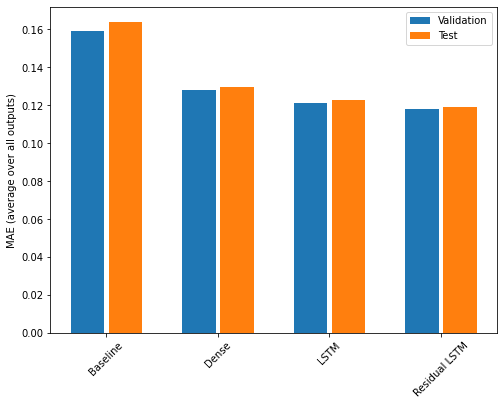

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1298
LSTM           : 0.1227
Residual LSTM  : 0.1190


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

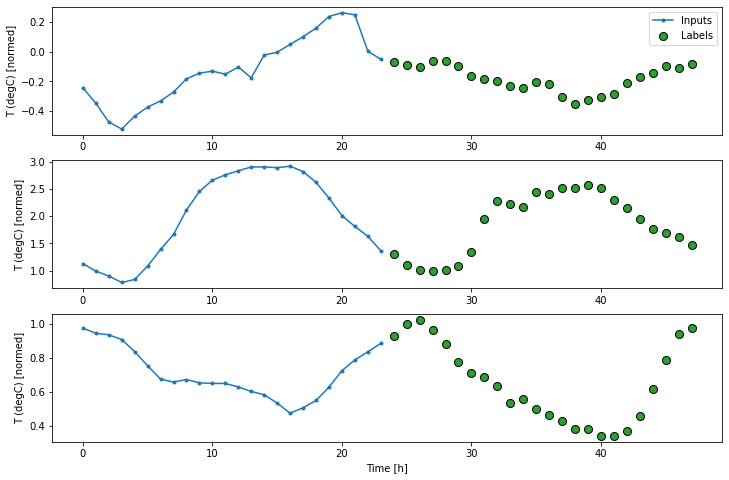

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output timesteps:

![Repeat the last input, for each output step](images/multistep_last.png)

  1/437 [..............................] - ETA: 1:00 - loss: 0.6197 - mean_absolute_error: 0.5200

 23/437 [>.............................] - ETA: 0s - loss: 0.5988 - mean_absolute_error: 0.4900  

 45/437 [==>...........................] - ETA: 0s - loss: 0.6146 - mean_absolute_error: 0.4971

 67/437 [===>..........................] - ETA: 0s - loss: 0.6172 - mean_absolute_error: 0.4980

 90/437 [=====>........................] - ETA: 0s - loss: 0.6175 - mean_absolute_error: 0.4978

113/437 [======>.......................] - ETA: 0s - loss: 0.6175 - mean_absolute_error: 0.4975

136/437 [========>.....................] - ETA: 0s - loss: 0.6179 - mean_absolute_error: 0.4975

159/437 [=========>....................] - ETA: 0s - loss: 0.6189 - mean_absolute_error: 0.4978

182/437 [===========>..................] - ETA: 0s - loss: 0.6198 - mean_absolute_error: 0.4981

205/437 [=============>................] - ETA: 0s - loss: 0.6205 - mean_absolute_error: 0.4984

228/437 [==============>...............] - ETA: 0s - loss: 0.6210 - mean_absolute_error: 0.4986

251/437 [================>.............] - ETA: 0s - loss: 0.6215 - mean_absolute_error: 0.4988

274/437 [=================>............] - ETA: 0s - loss: 0.6218 - mean_absolute_error: 0.4989

297/437 [===================>..........] - ETA: 0s - loss: 0.6220 - mean_absolute_error: 0.4989

320/437 [====================>.........] - ETA: 0s - loss: 0.6223 - mean_absolute_error: 0.4990

343/437 [======================>.......] - ETA: 0s - loss: 0.6225 - mean_absolute_error: 0.4991

366/437 [========================>.....] - ETA: 0s - loss: 0.6227 - mean_absolute_error: 0.4991

389/437 [=========================>....] - ETA: 0s - loss: 0.6230 - mean_absolute_error: 0.4992

412/437 [===========================>..] - ETA: 0s - loss: 0.6232 - mean_absolute_error: 0.4993

433/437 [============================>.] - ETA: 0s - loss: 0.6235 - mean_absolute_error: 0.4993

437/437 [==============================] - 1s 2ms/step - loss: 0.6235 - mean_absolute_error: 0.4994


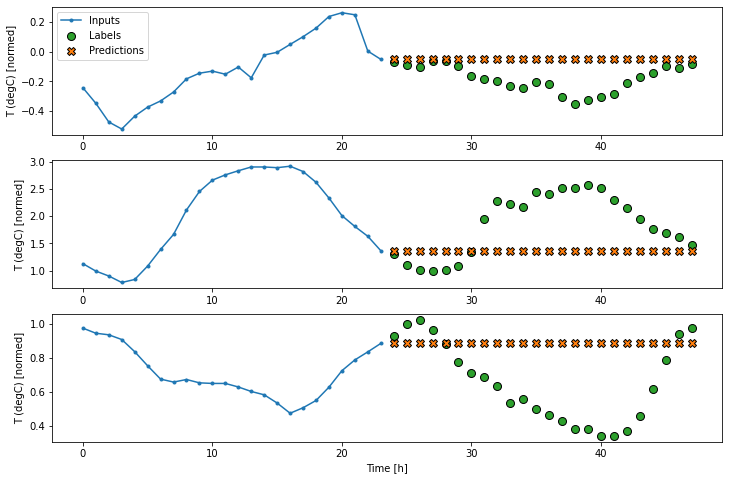

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](images/multistep_repeat.png)

  1/437 [..............................] - ETA: 54s - loss: 0.3930 - mean_absolute_error: 0.3980

 24/437 [>.............................] - ETA: 0s - loss: 0.3992 - mean_absolute_error: 0.3868 

 47/437 [==>...........................] - ETA: 0s - loss: 0.4103 - mean_absolute_error: 0.3912

 70/437 [===>..........................] - ETA: 0s - loss: 0.4147 - mean_absolute_error: 0.3926

 93/437 [=====>........................] - ETA: 0s - loss: 0.4163 - mean_absolute_error: 0.3930

116/437 [======>.......................] - ETA: 0s - loss: 0.4169 - mean_absolute_error: 0.3930

139/437 [========>.....................] - ETA: 0s - loss: 0.4178 - mean_absolute_error: 0.3932

161/437 [==========>...................] - ETA: 0s - loss: 0.4189 - mean_absolute_error: 0.3936

184/437 [===========>..................] - ETA: 0s - loss: 0.4199 - mean_absolute_error: 0.3939

206/437 [=============>................] - ETA: 0s - loss: 0.4205 - mean_absolute_error: 0.3941

229/437 [==============>...............] - ETA: 0s - loss: 0.4211 - mean_absolute_error: 0.3943

252/437 [================>.............] - ETA: 0s - loss: 0.4216 - mean_absolute_error: 0.3945

275/437 [=================>............] - ETA: 0s - loss: 0.4220 - mean_absolute_error: 0.3946

297/437 [===================>..........] - ETA: 0s - loss: 0.4223 - mean_absolute_error: 0.3947

320/437 [====================>.........] - ETA: 0s - loss: 0.4225 - mean_absolute_error: 0.3947

343/437 [======================>.......] - ETA: 0s - loss: 0.4227 - mean_absolute_error: 0.3948

366/437 [========================>.....] - ETA: 0s - loss: 0.4230 - mean_absolute_error: 0.3948

389/437 [=========================>....] - ETA: 0s - loss: 0.4232 - mean_absolute_error: 0.3949

412/437 [===========================>..] - ETA: 0s - loss: 0.4235 - mean_absolute_error: 0.3950

431/437 [============================>.] - ETA: 0s - loss: 0.4236 - mean_absolute_error: 0.3950

437/437 [==============================] - 1s 2ms/step - loss: 0.4237 - mean_absolute_error: 0.3950


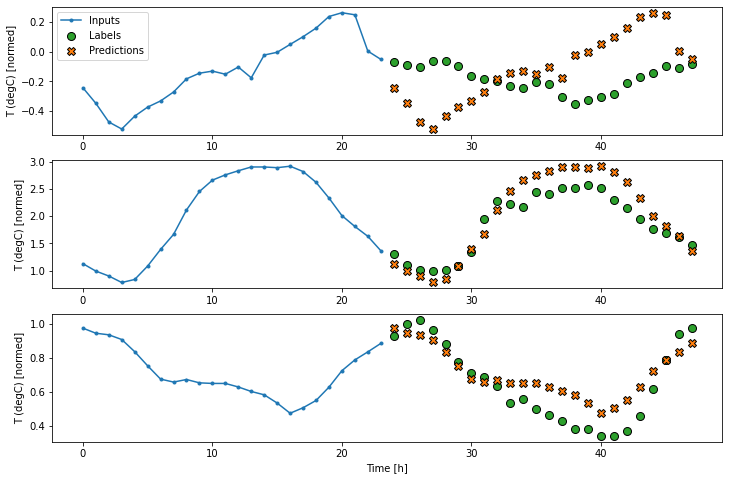

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predct all timesteps from the last time-step](images/multistep_dense.png)

  1/437 [..............................] - ETA: 22s - loss: 0.2719 - mean_absolute_error: 0.3233

 21/437 [>.............................] - ETA: 1s - loss: 0.2620 - mean_absolute_error: 0.3090 

 41/437 [=>............................] - ETA: 1s - loss: 0.2558 - mean_absolute_error: 0.3042

 60/437 [===>..........................] - ETA: 0s - loss: 0.2533 - mean_absolute_error: 0.3028

 80/437 [====>.........................] - ETA: 0s - loss: 0.2519 - mean_absolute_error: 0.3024

100/437 [=====>........................] - ETA: 0s - loss: 0.2527 - mean_absolute_error: 0.3023

120/437 [=======>......................] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.3028

139/437 [========>.....................] - ETA: 0s - loss: 0.2530 - mean_absolute_error: 0.3030

159/437 [=========>....................] - ETA: 0s - loss: 0.2514 - mean_absolute_error: 0.3021

179/437 [===========>..................] - ETA: 0s - loss: 0.2518 - mean_absolute_error: 0.3026

199/437 [============>.................] - ETA: 0s - loss: 0.2534 - mean_absolute_error: 0.3037

219/437 [==============>...............] - ETA: 0s - loss: 0.2523 - mean_absolute_error: 0.3032

239/437 [===============>..............] - ETA: 0s - loss: 0.2531 - mean_absolute_error: 0.3036

259/437 [================>.............] - ETA: 0s - loss: 0.2546 - mean_absolute_error: 0.3042

279/437 [==================>...........] - ETA: 0s - loss: 0.2551 - mean_absolute_error: 0.3043

300/437 [===================>..........] - ETA: 0s - loss: 0.2558 - mean_absolute_error: 0.3047

321/437 [=====================>........] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3049

342/437 [======================>.......] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3050

362/437 [=======================>......] - ETA: 0s - loss: 0.2565 - mean_absolute_error: 0.3051

382/437 [=========================>....] - ETA: 0s - loss: 0.2563 - mean_absolute_error: 0.3050

402/437 [==========================>...] - ETA: 0s - loss: 0.2561 - mean_absolute_error: 0.3049

422/437 [===========================>..] - ETA: 0s - loss: 0.2560 - mean_absolute_error: 0.3049

437/437 [==============================] - 1s 3ms/step - loss: 0.2556 - mean_absolute_error: 0.3046


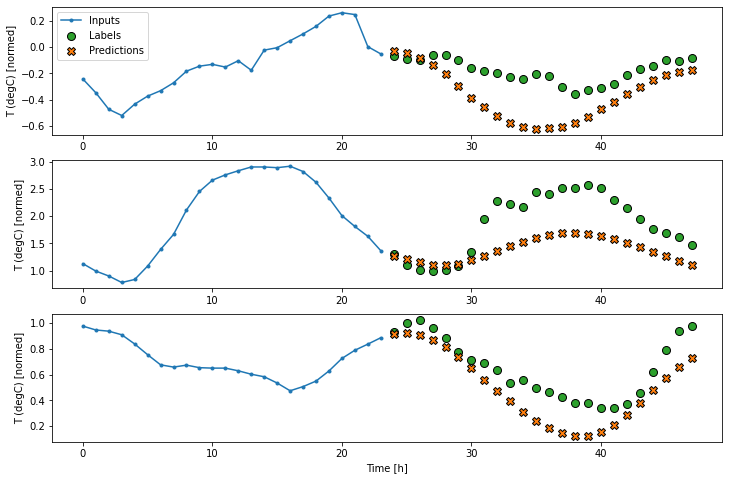

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

  1/437 [..............................] - ETA: 24s - loss: 0.2379 - mean_absolute_error: 0.2859

 17/437 [>.............................] - ETA: 1s - loss: 0.2283 - mean_absolute_error: 0.2876 

 33/437 [=>............................] - ETA: 1s - loss: 0.2220 - mean_absolute_error: 0.2828

 50/437 [==>...........................] - ETA: 1s - loss: 0.2208 - mean_absolute_error: 0.2832

 67/437 [===>..........................] - ETA: 1s - loss: 0.2197 - mean_absolute_error: 0.2826

 84/437 [====>.........................] - ETA: 1s - loss: 0.2198 - mean_absolute_error: 0.2827

101/437 [=====>........................] - ETA: 1s - loss: 0.2219 - mean_absolute_error: 0.2837

118/437 [=======>......................] - ETA: 0s - loss: 0.2212 - mean_absolute_error: 0.2832

134/437 [========>.....................] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2823

151/437 [=========>....................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2819

168/437 [==========>...................] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2821

185/437 [===========>..................] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2823

202/437 [============>.................] - ETA: 0s - loss: 0.2196 - mean_absolute_error: 0.2823

219/437 [==============>...............] - ETA: 0s - loss: 0.2201 - mean_absolute_error: 0.2824

236/437 [===============>..............] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2821

253/437 [================>.............] - ETA: 0s - loss: 0.2191 - mean_absolute_error: 0.2817

270/437 [=================>............] - ETA: 0s - loss: 0.2193 - mean_absolute_error: 0.2818

287/437 [==================>...........] - ETA: 0s - loss: 0.2188 - mean_absolute_error: 0.2816

303/437 [===================>..........] - ETA: 0s - loss: 0.2189 - mean_absolute_error: 0.2818

320/437 [====================>.........] - ETA: 0s - loss: 0.2194 - mean_absolute_error: 0.2822

337/437 [======================>.......] - ETA: 0s - loss: 0.2199 - mean_absolute_error: 0.2824

354/437 [=======================>......] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.2822

371/437 [========================>.....] - ETA: 0s - loss: 0.2195 - mean_absolute_error: 0.2822

388/437 [=========================>....] - ETA: 0s - loss: 0.2187 - mean_absolute_error: 0.2817

405/437 [==========================>...] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2815

422/437 [===========================>..] - ETA: 0s - loss: 0.2184 - mean_absolute_error: 0.2815

437/437 [==============================] - 1s 3ms/step - loss: 0.2181 - mean_absolute_error: 0.2814


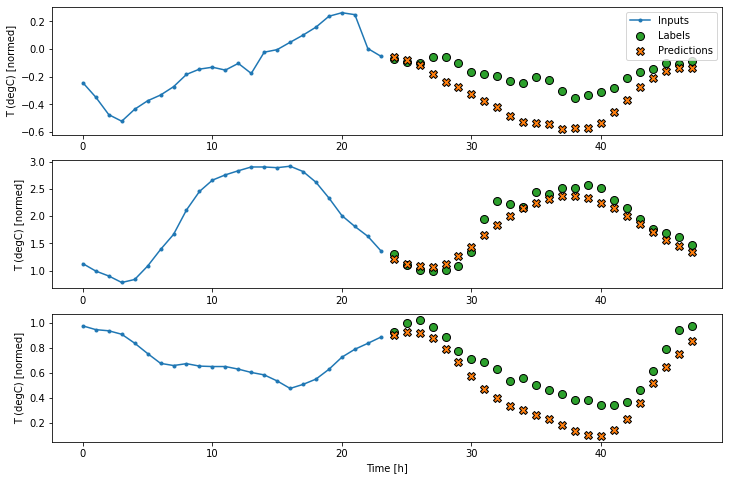

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](images/multistep_conv.png)

  1/437 [..............................] - ETA: 23s - loss: 0.1918 - mean_absolute_error: 0.2646

 18/437 [>.............................] - ETA: 1s - loss: 0.2025 - mean_absolute_error: 0.2726 

 35/437 [=>............................] - ETA: 1s - loss: 0.2079 - mean_absolute_error: 0.2770

 52/437 [==>...........................] - ETA: 1s - loss: 0.2082 - mean_absolute_error: 0.2775

 70/437 [===>..........................] - ETA: 1s - loss: 0.2111 - mean_absolute_error: 0.2787

 87/437 [====>.........................] - ETA: 1s - loss: 0.2128 - mean_absolute_error: 0.2802

104/437 [======>.......................] - ETA: 1s - loss: 0.2148 - mean_absolute_error: 0.2812

121/437 [=======>......................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2808

138/437 [========>.....................] - ETA: 0s - loss: 0.2138 - mean_absolute_error: 0.2805

155/437 [=========>....................] - ETA: 0s - loss: 0.2143 - mean_absolute_error: 0.2807

172/437 [==========>...................] - ETA: 0s - loss: 0.2144 - mean_absolute_error: 0.2808

189/437 [===========>..................] - ETA: 0s - loss: 0.2141 - mean_absolute_error: 0.2806

206/437 [=============>................] - ETA: 0s - loss: 0.2140 - mean_absolute_error: 0.2807

223/437 [==============>...............] - ETA: 0s - loss: 0.2145 - mean_absolute_error: 0.2810

240/437 [===============>..............] - ETA: 0s - loss: 0.2153 - mean_absolute_error: 0.2813

257/437 [================>.............] - ETA: 0s - loss: 0.2152 - mean_absolute_error: 0.2813

274/437 [=================>............] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2820

292/437 [===================>..........] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2822

309/437 [====================>.........] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2820

326/437 [=====================>........] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2821

343/437 [======================>.......] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2823

361/437 [=======================>......] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2820

378/437 [========================>.....] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2817

396/437 [==========================>...] - ETA: 0s - loss: 0.2159 - mean_absolute_error: 0.2818

414/437 [===========================>..] - ETA: 0s - loss: 0.2157 - mean_absolute_error: 0.2817

431/437 [============================>.] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2820

437/437 [==============================] - 1s 3ms/step - loss: 0.2161 - mean_absolute_error: 0.2819


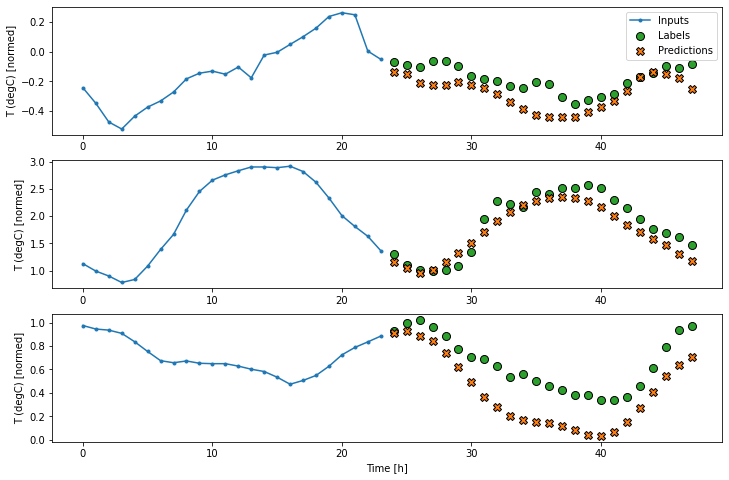

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](images/multistep_lstm.png)


  1/437 [..............................] - ETA: 24s - loss: 0.2273 - mean_absolute_error: 0.2908

 16/437 [>.............................] - ETA: 1s - loss: 0.2231 - mean_absolute_error: 0.2919 

 32/437 [=>............................] - ETA: 1s - loss: 0.2175 - mean_absolute_error: 0.2878

 48/437 [==>...........................] - ETA: 1s - loss: 0.2176 - mean_absolute_error: 0.2882

 64/437 [===>..........................] - ETA: 1s - loss: 0.2194 - mean_absolute_error: 0.2885

 79/437 [====>.........................] - ETA: 1s - loss: 0.2178 - mean_absolute_error: 0.2883

 95/437 [=====>........................] - ETA: 1s - loss: 0.2173 - mean_absolute_error: 0.2877

111/437 [======>.......................] - ETA: 1s - loss: 0.2163 - mean_absolute_error: 0.2868

127/437 [=======>......................] - ETA: 1s - loss: 0.2164 - mean_absolute_error: 0.2867

143/437 [========>.....................] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2863

159/437 [=========>....................] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2866

175/437 [===========>..................] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2864

191/437 [============>.................] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2867

207/437 [=============>................] - ETA: 0s - loss: 0.2171 - mean_absolute_error: 0.2869

223/437 [==============>...............] - ETA: 0s - loss: 0.2172 - mean_absolute_error: 0.2869

238/437 [===============>..............] - ETA: 0s - loss: 0.2167 - mean_absolute_error: 0.2866

254/437 [================>.............] - ETA: 0s - loss: 0.2169 - mean_absolute_error: 0.2868

270/437 [=================>............] - ETA: 0s - loss: 0.2163 - mean_absolute_error: 0.2865

286/437 [==================>...........] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2867

302/437 [===================>..........] - ETA: 0s - loss: 0.2160 - mean_absolute_error: 0.2865

318/437 [====================>.........] - ETA: 0s - loss: 0.2158 - mean_absolute_error: 0.2863

334/437 [=====================>........] - ETA: 0s - loss: 0.2162 - mean_absolute_error: 0.2865

350/437 [=======================>......] - ETA: 0s - loss: 0.2166 - mean_absolute_error: 0.2868

366/437 [========================>.....] - ETA: 0s - loss: 0.2165 - mean_absolute_error: 0.2869

382/437 [=========================>....] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2871

398/437 [==========================>...] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2871

414/437 [===========================>..] - ETA: 0s - loss: 0.2168 - mean_absolute_error: 0.2871

430/437 [============================>.] - ETA: 0s - loss: 0.2164 - mean_absolute_error: 0.2869

437/437 [==============================] - 1s 3ms/step - loss: 0.2167 - mean_absolute_error: 0.2870


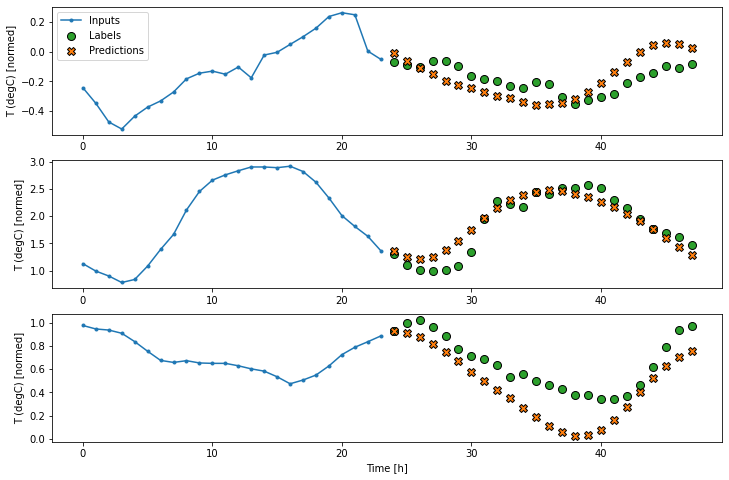

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence as a in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of single single-step multi-output models trained in the first half of this tutorial and run  in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](images/multistep_autoregressive.png)


#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single timestep.

The model will have the same basic form as the single-step `LSTM` models: An `LSTM` followed by a `layers.Dense` that converts the `LSTM` outputs to model predictions.

A `layers.LSTM` is a `layers.LSTMCell` wrapped in the higher level `layers.RNN` that manages the state and sequence results for you (See [Keras RNNs](https://www.tensorflow.org/guide/keras/rnn) for details).

In this case the model has to manually manage the inputs for each step so it uses `layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction, and the internal state of the LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and `tf.stack` after the loop.

Note: Stacking a python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length you would need to use a `tf.TensorArray` instead of a python list, and `tf.range` instead of the python `range`.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now train the model:

  1/437 [..............................] - ETA: 25s - loss: 0.2019 - mean_absolute_error: 0.2949

  8/437 [..............................] - ETA: 3s - loss: 0.2285 - mean_absolute_error: 0.3028 

 15/437 [>.............................] - ETA: 3s - loss: 0.2279 - mean_absolute_error: 0.3015

 22/437 [>.............................] - ETA: 3s - loss: 0.2305 - mean_absolute_error: 0.3015

 29/437 [>.............................] - ETA: 3s - loss: 0.2247 - mean_absolute_error: 0.2966

 36/437 [=>............................] - ETA: 3s - loss: 0.2212 - mean_absolute_error: 0.2945

 43/437 [=>............................] - ETA: 3s - loss: 0.2218 - mean_absolute_error: 0.2950

 50/437 [==>...........................] - ETA: 3s - loss: 0.2228 - mean_absolute_error: 0.2957

 56/437 [==>...........................] - ETA: 3s - loss: 0.2234 - mean_absolute_error: 0.2962

 63/437 [===>..........................] - ETA: 3s - loss: 0.2250 - mean_absolute_error: 0.2964

 70/437 [===>..........................] - ETA: 2s - loss: 0.2235 - mean_absolute_error: 0.2957

 77/437 [====>.........................] - ETA: 2s - loss: 0.2241 - mean_absolute_error: 0.2961

 84/437 [====>.........................] - ETA: 2s - loss: 0.2239 - mean_absolute_error: 0.2961

 91/437 [=====>........................] - ETA: 2s - loss: 0.2252 - mean_absolute_error: 0.2967

 97/437 [=====>........................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.2968

104/437 [======>.......................] - ETA: 2s - loss: 0.2257 - mean_absolute_error: 0.2967

111/437 [======>.......................] - ETA: 2s - loss: 0.2259 - mean_absolute_error: 0.2966

118/437 [=======>......................] - ETA: 2s - loss: 0.2262 - mean_absolute_error: 0.2965

125/437 [=======>......................] - ETA: 2s - loss: 0.2269 - mean_absolute_error: 0.2970

132/437 [========>.....................] - ETA: 2s - loss: 0.2269 - mean_absolute_error: 0.2967

139/437 [========>.....................] - ETA: 2s - loss: 0.2272 - mean_absolute_error: 0.2969

146/437 [=========>....................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.2964

153/437 [=========>....................] - ETA: 2s - loss: 0.2259 - mean_absolute_error: 0.2962

160/437 [=========>....................] - ETA: 2s - loss: 0.2256 - mean_absolute_error: 0.2963

167/437 [==========>...................] - ETA: 2s - loss: 0.2263 - mean_absolute_error: 0.2966

174/437 [==========>...................] - ETA: 2s - loss: 0.2269 - mean_absolute_error: 0.2970

181/437 [===========>..................] - ETA: 2s - loss: 0.2272 - mean_absolute_error: 0.2971

188/437 [===========>..................] - ETA: 2s - loss: 0.2274 - mean_absolute_error: 0.2972

195/437 [============>.................] - ETA: 1s - loss: 0.2275 - mean_absolute_error: 0.2972

202/437 [============>.................] - ETA: 1s - loss: 0.2275 - mean_absolute_error: 0.2971

209/437 [=============>................] - ETA: 1s - loss: 0.2275 - mean_absolute_error: 0.2971

216/437 [=============>................] - ETA: 1s - loss: 0.2280 - mean_absolute_error: 0.2974

223/437 [==============>...............] - ETA: 1s - loss: 0.2279 - mean_absolute_error: 0.2974

230/437 [==============>...............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.2975

237/437 [===============>..............] - ETA: 1s - loss: 0.2284 - mean_absolute_error: 0.2977

244/437 [===============>..............] - ETA: 1s - loss: 0.2282 - mean_absolute_error: 0.2976

251/437 [================>.............] - ETA: 1s - loss: 0.2279 - mean_absolute_error: 0.2976

258/437 [================>.............] - ETA: 1s - loss: 0.2273 - mean_absolute_error: 0.2973

265/437 [=================>............] - ETA: 1s - loss: 0.2271 - mean_absolute_error: 0.2973

272/437 [=================>............] - ETA: 1s - loss: 0.2275 - mean_absolute_error: 0.2975

279/437 [==================>...........] - ETA: 1s - loss: 0.2275 - mean_absolute_error: 0.2976

286/437 [==================>...........] - ETA: 1s - loss: 0.2272 - mean_absolute_error: 0.2975

293/437 [===================>..........] - ETA: 1s - loss: 0.2278 - mean_absolute_error: 0.2979

300/437 [===================>..........] - ETA: 1s - loss: 0.2277 - mean_absolute_error: 0.2979

307/437 [====================>.........] - ETA: 1s - loss: 0.2277 - mean_absolute_error: 0.2980

314/437 [====================>.........] - ETA: 0s - loss: 0.2280 - mean_absolute_error: 0.2980

321/437 [=====================>........] - ETA: 0s - loss: 0.2286 - mean_absolute_error: 0.2984

328/437 [=====================>........] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.2983

335/437 [=====================>........] - ETA: 0s - loss: 0.2283 - mean_absolute_error: 0.2982

342/437 [======================>.......] - ETA: 0s - loss: 0.2283 - mean_absolute_error: 0.2982

349/437 [======================>.......] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.2980

356/437 [=======================>......] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.2980

363/437 [=======================>......] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.2980

370/437 [========================>.....] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.2980

377/437 [========================>.....] - ETA: 0s - loss: 0.2280 - mean_absolute_error: 0.2978

384/437 [=========================>....] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.2980

391/437 [=========================>....] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.2980

398/437 [==========================>...] - ETA: 0s - loss: 0.2284 - mean_absolute_error: 0.2981

405/437 [==========================>...] - ETA: 0s - loss: 0.2282 - mean_absolute_error: 0.2980

412/437 [===========================>..] - ETA: 0s - loss: 0.2281 - mean_absolute_error: 0.2979

419/437 [===========================>..] - ETA: 0s - loss: 0.2280 - mean_absolute_error: 0.2979

426/437 [============================>.] - ETA: 0s - loss: 0.2278 - mean_absolute_error: 0.2978

433/437 [============================>.] - ETA: 0s - loss: 0.2275 - mean_absolute_error: 0.2977

437/437 [==============================] - 4s 8ms/step - loss: 0.2273 - mean_absolute_error: 0.2976


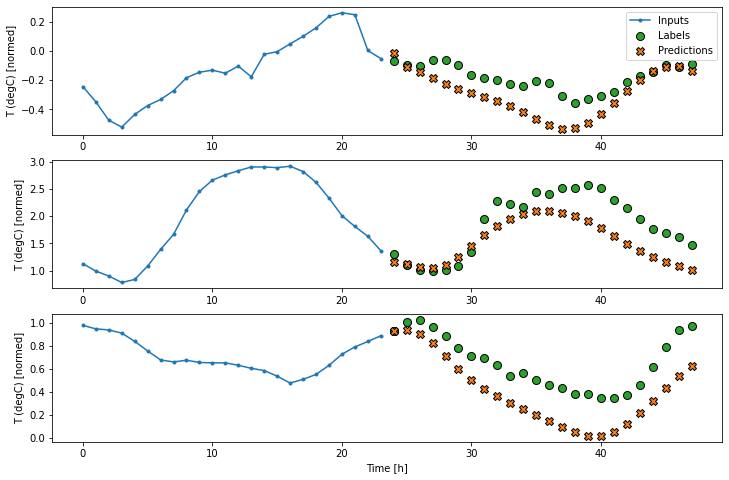

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem.

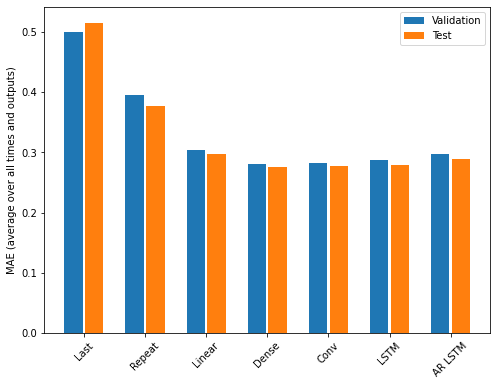

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2766
Conv    : 0.2768
LSTM    : 0.2787
AR LSTM : 0.2884


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

* For further understanding, see:
  * Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition 
  * Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).
  * Lesson 8 of [Udacity's intro to TensorFlow for deep learning](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187), and the [exercise notebooks](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning) 
* Also remember that you can implement any [classical time series model](https://otexts.com/fpp2/index.html) in TensorFlow, this tutorial just focuses on TensorFlow's built-in functionality.